# Part A: Time Series

|            Name          |    Admin No.   |        Class      |
|:-------------------------:|:---------------:|:------------------:|
|   Timothy Chia Kai Lun   |    P2106911    |   DAAA/FT/2A/02   |

**<u>Background</u>**
-  Using  air-pollution  dataset  to  train a  time  series model for future air  pollution forecasting. 
-  You will be given a training dataset to build your time series model, and to make prediction using the test dataset. 


**<u>Tasks</u>**

1. Write the code to solve the  time series prediction. For the time series model, use Statsmodels only (do not use other 3rd party libraries such as autoML). 
2. Tune the hyperparameters of the time series model to maximize the accuracy for in-sample and out-of-sample prediction. 
3. Write  a  short  report  detailing  your  implementation,  your  experiments  and analysis in the Jupyter notebook (along with your python code and comments). 
4. Create a set of slides with the highlights of your Jupyter notebook. Explain the time series prediction process, model building and evaluation. Write your conclusions. 
5. Using the most optimized model, make a prediction with the testing set, and submit your solution in the Kaggle competition (using the sample_submission.csv template). Remember, before you make the submission on Kaggle, change your Kaggle team name to the format “class-name”, such as “2A01-Justin”, so that we can identify you.

## Importing Libraries

Before performing any analysis or modelling, the first step in every project will be to import the essential libraries.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Statistical Tests, Plots, and Visualizations
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests, coint
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Model Selection Utils and Metrics
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tools.eval_measures import mse, rmse, meanabs 

# Forecasting Model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Exporting Models
import os
import pickle

# Miscellaneous
from warnings import filterwarnings

filterwarnings(action='ignore')
sns.set_theme()
sns.set(rc={'figure.figsize' : (30, 10)})

## Import Dataset

I then imported the dataset downloaded from Kaggle as stated in the assignment brief.

In [4]:
data = pd.read_csv('./data/Air Pollution Dataset/train.csv')

## Data Dictionary



|    Feature    |                 Desciption          |
|---------------|-------------------------------------|
|    Date       |   Date in DD/MM/YYYY format         |
|      T        |   Temperature in degrees celcius    |
|     RH        |   Relative Humidity in percentages  |
|    Value      |   Pollution Value                   |



## Descriptive Analysis

I would like to find out characteristics and structure of the provided dataset. Hence I will be performing some exploratory analysis

In [5]:
data.head()

,Date,T,RH,Gas,Value
0,15/3/2016,12.020833,54.883334,CO,1053.200000
1,16/3/2016,9.833333,64.069791,CO,995.250000
2,17/3/2016,11.292708,51.107292,CO,1025.250000
3,18/3/2016,12.866319,51.530903,CO,1064.444444
4,19/3/2016,16.016667,48.843750,CO,1088.741667


**<u>Observations</u>**

- Taking a peek at the first five columns, the dataset seems to contain different data types such as dates, floats and strings.
- It seems that each row corresponds to the recorded pollution level of each gas type along with temperature and therelative humidity for each respective day.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1312 entries, 0 to 1311
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1312 non-null   object 
 1   T       1312 non-null   float64
 2   RH      1312 non-null   float64
 3   Gas     1312 non-null   object 
 4   Value   1312 non-null   float64
dtypes: float64(3), object(2)
memory usage: 51.4+ KB


**<u>Observations</u>**

- The dataset contains 1311 rows and 5 columns.
- The `Date` column is in string data type.
- Having artificial values as an index for the dataset would make our analysis more challenging.

**<u>Action</u>**

- Change `Date` to datetime datatype.
- Since the pandas library is built to handle time series data, it would be more efficient to set the `Date` column as the index.

In [7]:
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data.set_index('Date', inplace=True)

In [8]:
data.index

DatetimeIndex(['2016-03-15', '2016-03-16', '2016-03-17', '2016-03-18',
               '2016-03-19', '2016-03-20', '2016-03-21', '2016-03-22',
               '2016-03-23', '2016-03-24',
               ...
               '2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30',
               '2017-01-31', '2017-02-01', '2017-02-02', '2017-02-03',
               '2017-02-04', '2017-02-05'],
              dtype='datetime64[ns]', name='Date', length=1312, freq=None)

**<u>Observations</u>**

- Looking at the frequency of dates, this dataset seems to contain daily records.

In [9]:
print(f'Duplicate indexes: {data.index.duplicated().sum()}')

Duplicate indexes: 984


**<u>Observations</u>**

- The dataset contains duplicate date values which I found perculiar.
- This could mean that there are duplicate date indexes for each gas type being recorded .

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
T,1312.0,11.634917,37.041779,-200.0,12.387760,18.832292,25.557118,32.997917
RH,1312.0,39.873729,43.217836,-200.0,36.348177,46.078993,57.932292,81.104167
Value,1312.0,750.218839,225.520132,-160.0,648.370833,769.370833,880.570833,1436.233333


**<u>Observations</u>**

- I immediately noticed that values for `T`, `RH`, and `Value` had minimum values of -160 to -200 which does not make sense as these are very extreme values.
- Although the scale of values in `Value` are quite large compared to `T` and `RH`, these values will be investigated later via pivoting our dataset.

In [11]:
print(data['Gas'].unique())

['CO' 'HC' 'NO2' 'O3']


**<u>Observations</u>**

- Within the `Gas` column, we can see that our dataset holds records of 4 types of polluntant gases.
- These are carbon monoxide (CO), hydrocarbon (HC), nitrogen dioxide (NO2), and trioxygen (O3).

## Univariate Analysis

Next I plan to further analyse each feature within the dataset.

In [12]:
cols = ['T', 'RH', 'Value']

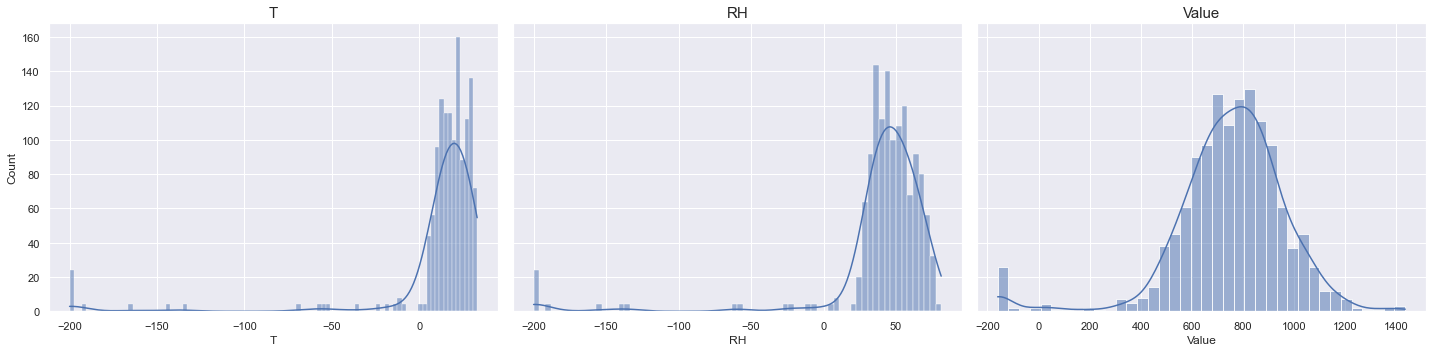

In [13]:
fig1, axes1 = plt.subplots(nrows=1, ncols=len(cols), figsize=(20, 5), sharey=True)

for col, ax in zip(cols, axes1.flatten()):
    sns.histplot(data[col], ax=ax, kde=True)
    ax.set_title(col, fontsize=15)
    
plt.tight_layout()
plt.show()

**<u>Observations</u>**

- The distributions of `T` and `RH` are extremely negatively skewed, with values as extreme as -200.
- The distribution of `Value` is alight negatively skewed with similar extreme values in the negative hundreds, although it seems quite normally distibuted at the same time.

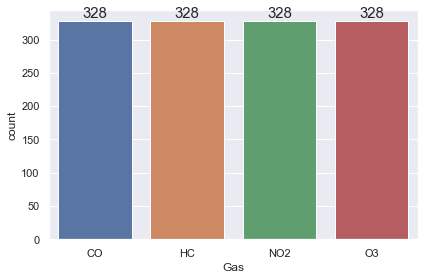

In [14]:
ax2 = sns.countplot(data['Gas'])
ax2.bar_label(ax2.containers[0], fontsize=15)

plt.tight_layout()
plt.show()

**<u>Observations</u>**

- There seems to be an equal number of records for each gas type within our dataset.

## Time Series Analysis

To make our gather more insights and make our analysis more thorough, I will reshape our dataset with pandas pivot method to have each column correspond to each gas type filled with their pollutant values.

In [15]:
df_copy = data.copy(deep=True)

pivot_df = pd.pivot(df_copy, columns='Gas', values='Value')
pivot_df[['T', 'RH']] =  df_copy[['T', 'RH']].groupby(df_copy.index).mean()

In [16]:
pivot_df.head()

Gas,CO,HC,NO2,O3,T,RH
Date,,,,,,
2016-03-15,1053.200000,729.800000,933.800000,876.833333,12.020833,54.883334
2016-03-16,995.250000,681.441667,1021.750000,708.025000,9.833333,64.069791
2016-03-17,1025.250000,806.583333,881.375000,867.375000,11.292708,51.107292
2016-03-18,1064.444444,794.258333,794.527778,996.625000,12.866319,51.530903
2016-03-19,1088.741667,755.083333,800.883333,987.341667,16.016667,48.843750


**<u>Observations</u>**

- Our reshaped dataset looks much better now :D

In [17]:
# Before changing time series frequency
print(len(pivot_df))

328


In [18]:
# After changing time series frequency
pivot_df = pivot_df.asfreq('D')
print(len(pivot_df))

328


In [19]:
# Checking for duplicate dat indexes
print(f'Duplicate indexes: {pivot_df.index.duplicated().sum()}')

Duplicate indexes: 0


**<u>Observations</u>**

- Our initial observations were that the dataset was in daily frequency, after pivoting the dataset to get rid of duplicate row indexes, we can see that changing the frequency of our time series to daily has no effect futher supporting that fact that the dataset contains daily data.

In [20]:
pivot_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Gas,,,,,,,,
CO,328.0,840.583477,204.831525,-160.0,779.191667,864.141667,946.431250,1210.566667
HC,328.0,729.588974,190.472814,-160.0,662.795833,753.681944,847.712500,1084.083333
NO2,328.0,650.087974,193.658229,-160.0,566.095833,659.325000,754.351389,1342.950000
O3,328.0,780.614931,261.846007,-160.0,639.850000,794.893056,944.608333,1436.233333
T,328.0,11.634917,37.084233,-200.0,12.387760,18.832292,25.557118,32.997917
RH,328.0,39.873729,43.267370,-200.0,36.348177,46.078993,57.932292,81.104167


**<u>Observations</u>**

- Taking a look at the statistics for each time series, it is interesting to know that the minimum values for all gas types are -160.

In [21]:
gases = ['CO', 'HC', 'NO2', 'O3']
t_rh = ['T', 'RH']

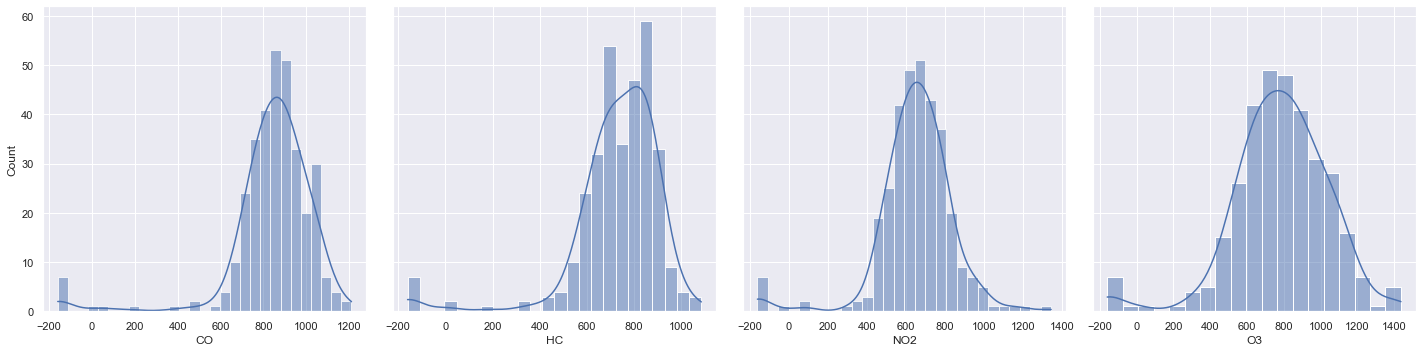

In [22]:
fig3, axes3 = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), sharey=True)

for col, ax in zip(gases, axes3.flatten()):
    sns.histplot(pivot_df[col], ax=ax, kde=True)
    
plt.tight_layout()
plt.show()

**<u>Observations</u>**

- Similar to our previous histogram plot on `Value`, the distributions of each gas type seems to follow a normal distribution with some negative skew due to the extreme negative values.

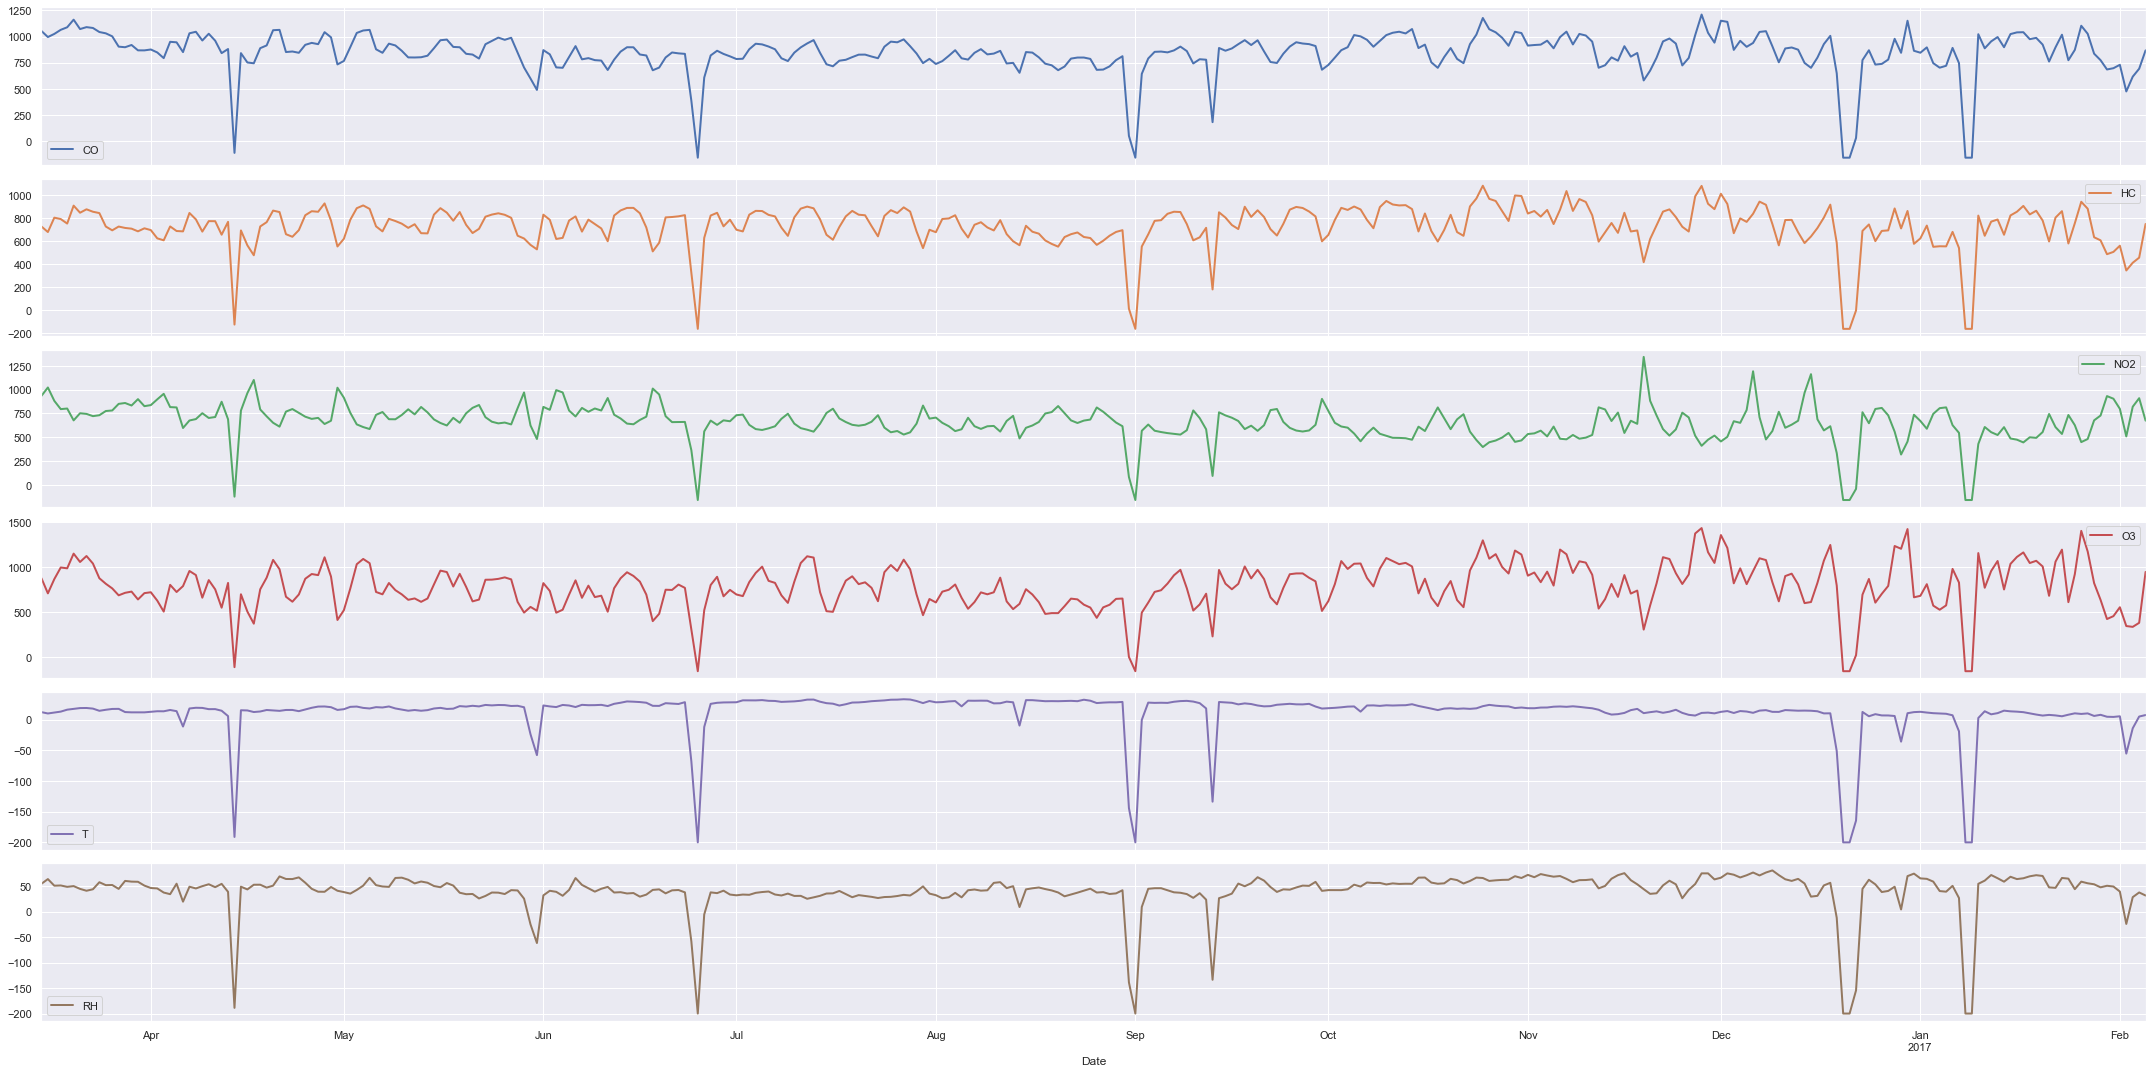

In [23]:
ax4 = pivot_df.plot(subplots=True, linewidth=2, figsize=(30, 15))

plt.tight_layout()
plt.show()

**<u>Observations</u>**

- Plotting out each time series, the extreme values are more evident. 
- It is argueable whether or not these sudden drop in values have any seasonal patterns but it will be discussed further on.

## Anomaly Detection 

These extreme values seem quite impossible for the following reasons:
1) Devices used to monitor gaseous pollutant, usually allow negative values, but have certain acceptable ranges (Technical Note ‐ Reporting Negative Values for Criteria Pollutant Gaseous Monitors to AQS, 2016).
2) Although sensors allow  negative relative humidity values to be registered these values are set to zero, and having negative values logically makes no sense (Humidity, 2000).

It should be quite evident that there is more to these extreme values. Hence, I will further analyse these observed extreme values to determine whether they can be considered outliers and handle them from there.

I will use Tuckey Fences to check for outliers, by the following critierion:


$$
[Q_1 - k(Q_3 - Q_1), Q_3 + k(Q_3 - Q_1)]
$$


an outlier is any data that lies outside the range. This method is applicable to skewed data since it makes no distributional assumptions and it does not depend on a mean or standard deviation. In this case, we will look at the extreme outliers (Tukey Fences for Outliers, 2021). 

It should be noted that for time series data, future information cannot be used to detect past outliers. Hence, outliers will be detected on a rolling basis.

In [24]:
def detect_outliers(df, col, k=1.5, window=7, lq=.25, uq=.75):
    temp = df[col].rolling(window)

    q1 = temp.quantile(lq)
    q3 = temp.quantile(uq)

    iqr = q3 - q1

    lower_fence = q1 - (k * iqr)
    upper_fence = q3 + (k * iqr)

    outliers = ~(df[col].between(lower_fence, upper_fence))

    return df[outliers][col]

def display_outliers(df, col):
    fig = plt.figure(figsize=(30, 3))

    outliers = detect_outliers(df, col)

    print(f'{col} Outliers: {len(outliers)}')

    df[col].plot(linewidth=2)
    plt.plot(outliers, 'ro')
    plt.title(col, fontsize=15)

    return fig

CO Outliers: 34
HC Outliers: 29
NO2 Outliers: 33
O3 Outliers: 27
T Outliers: 48
RH Outliers: 37


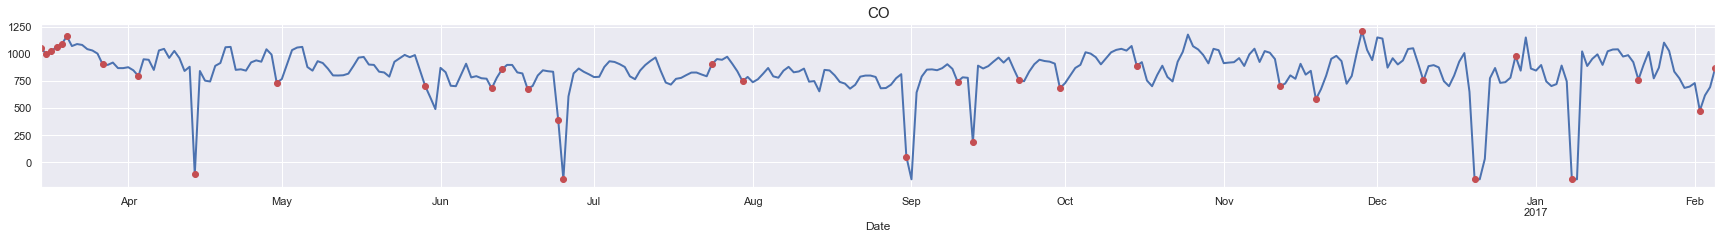

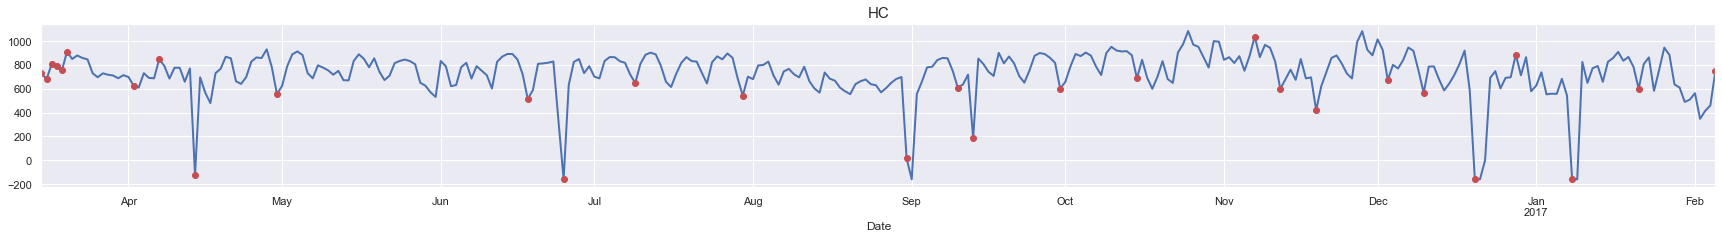

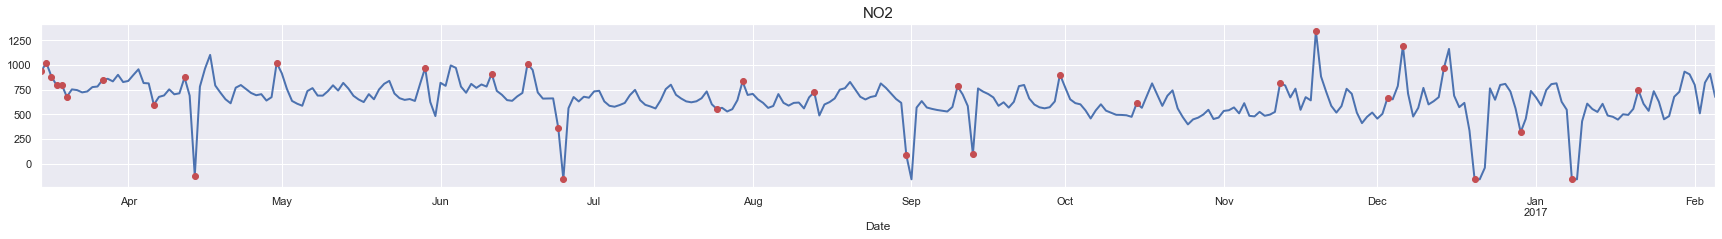

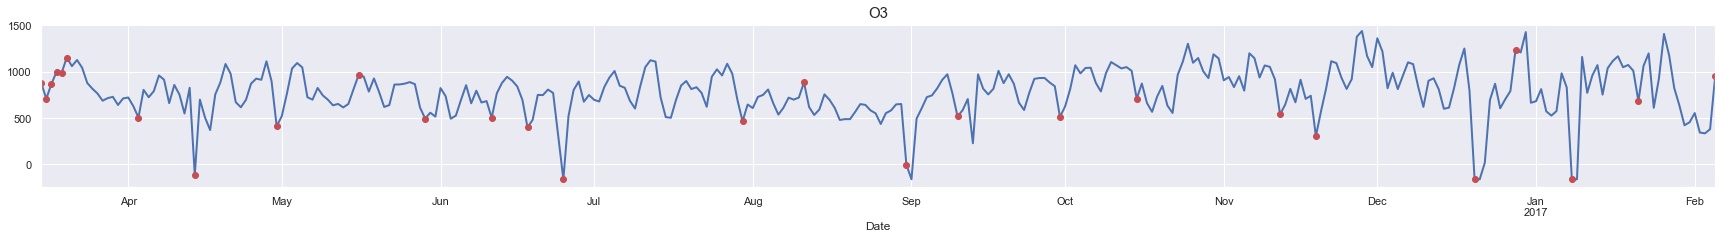

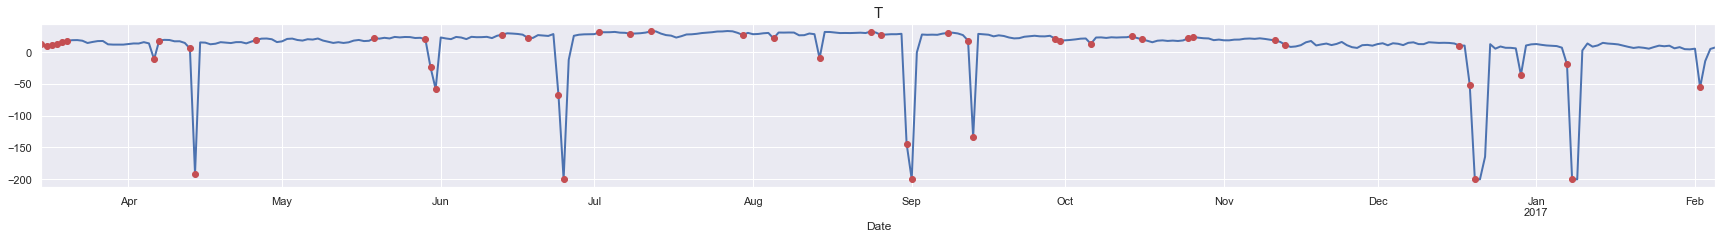

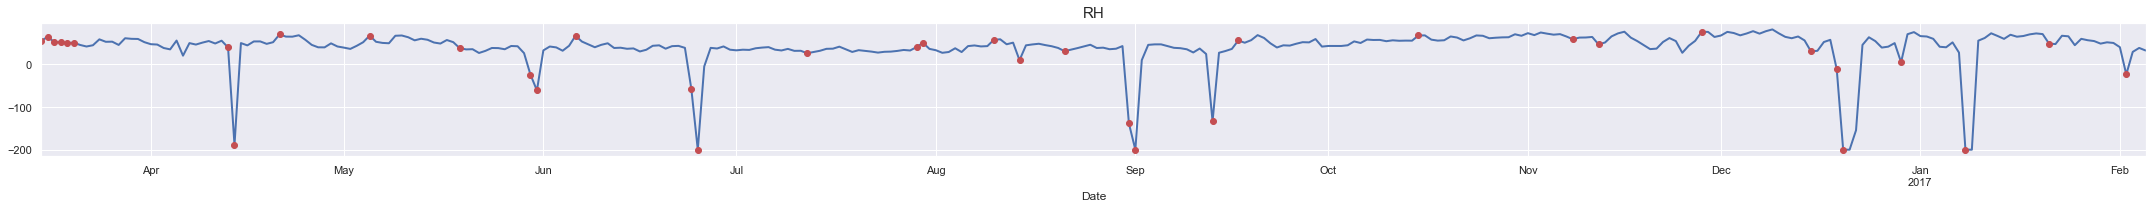

In [25]:
for col in pivot_df.columns:
    display_outliers(pivot_df, col)

plt.tight_layout()
plt.show()

**<u>Observations</u>**

- Visualising these anomalies, we can definitely say that thse extreme values are outliers.

**<u>Action</u>**

- However, removing or imputing these outliers can serverly affect our forecasting models accuracy later on as these outliers can be used to predict when future spikes on values may occur.
- Hence, these outliers will not be handled.

## STL Decomposition

Next, I will apply additive seasonal decomposition to our time series to check their:
- trend
- seasonality
- residuals

Each of these components are something we need to think about and address during model selection and model tuning. These can be addressed explicitly in terms of modeling the trend and subtracting it from our data, or implicitly by providing enough history for an algorithm to model a trend if it may exist.<br>

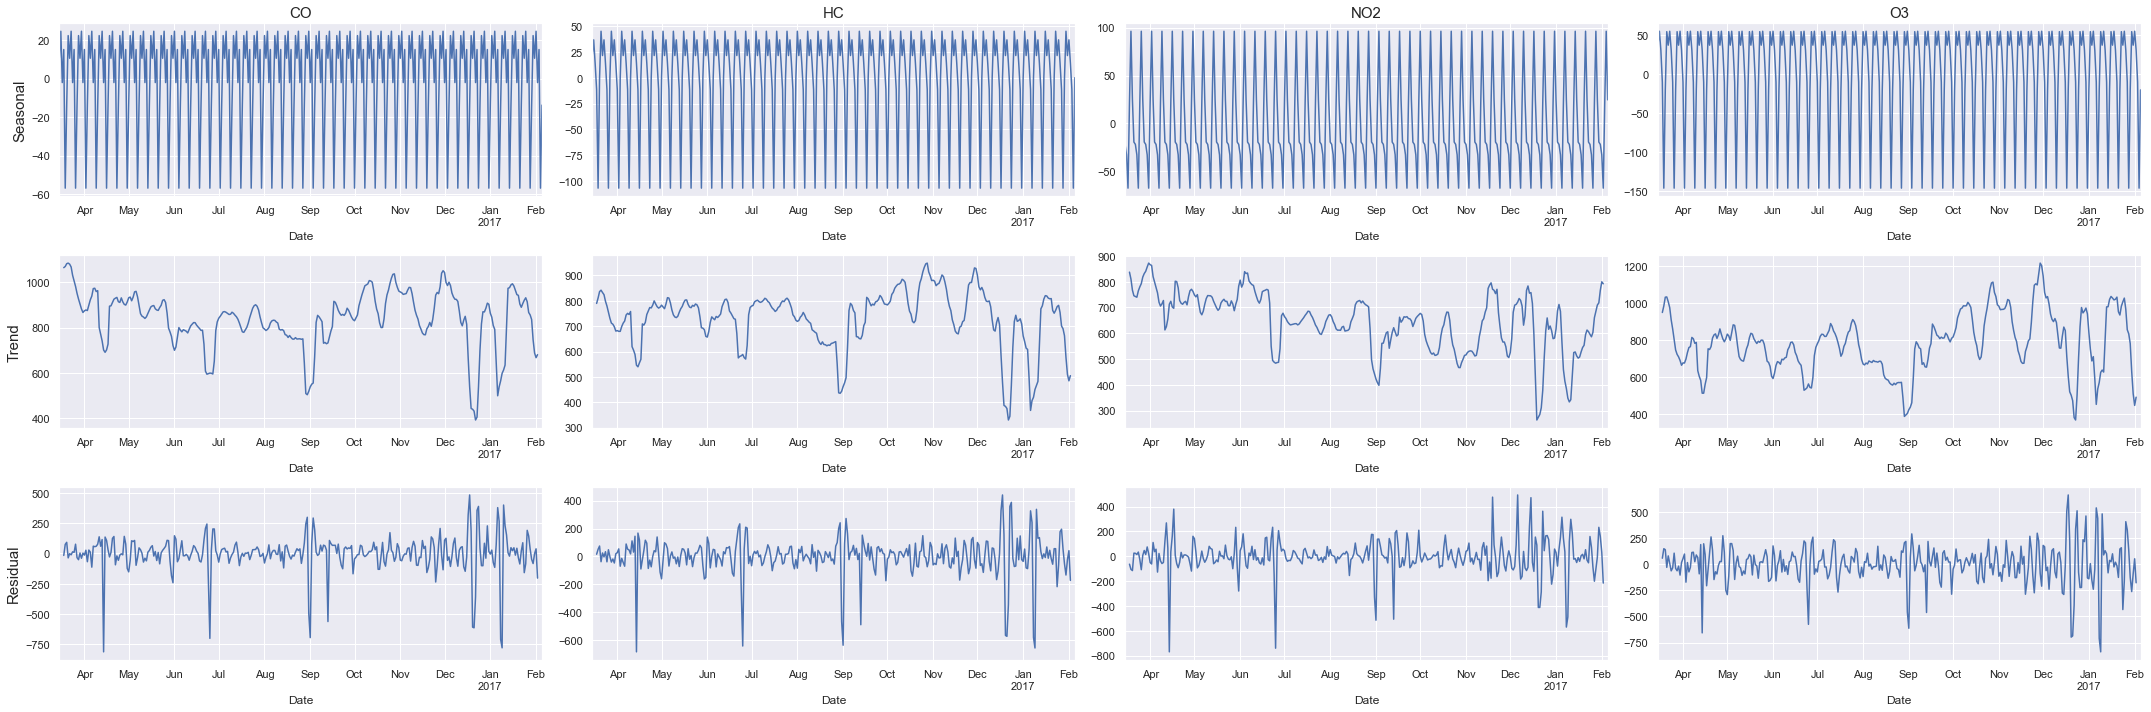

In [26]:
fig5, ax5 = plt.subplots(nrows=3, ncols=4, figsize=(30, 10))

for idx, col in enumerate(pivot_df.columns[:4]):
    results = seasonal_decompose(pivot_df[col], model='additive') #multiplicative not suitable for dataset as they contain negative values
    results.seasonal.plot(ax=ax5[0, idx])
    results.trend.plot(ax=ax5[1, idx])
    results.resid.plot(ax=ax5[2, idx])

    ax5[0, idx].set_title(col, fontsize=15)
    ax5[0, 0].set_ylabel('Seasonal', fontsize=15)
    ax5[1, 0].set_ylabel('Trend', fontsize=15)
    ax5[2, 0].set_ylabel('Residual', fontsize=15)

plt.tight_layout()
plt.show()

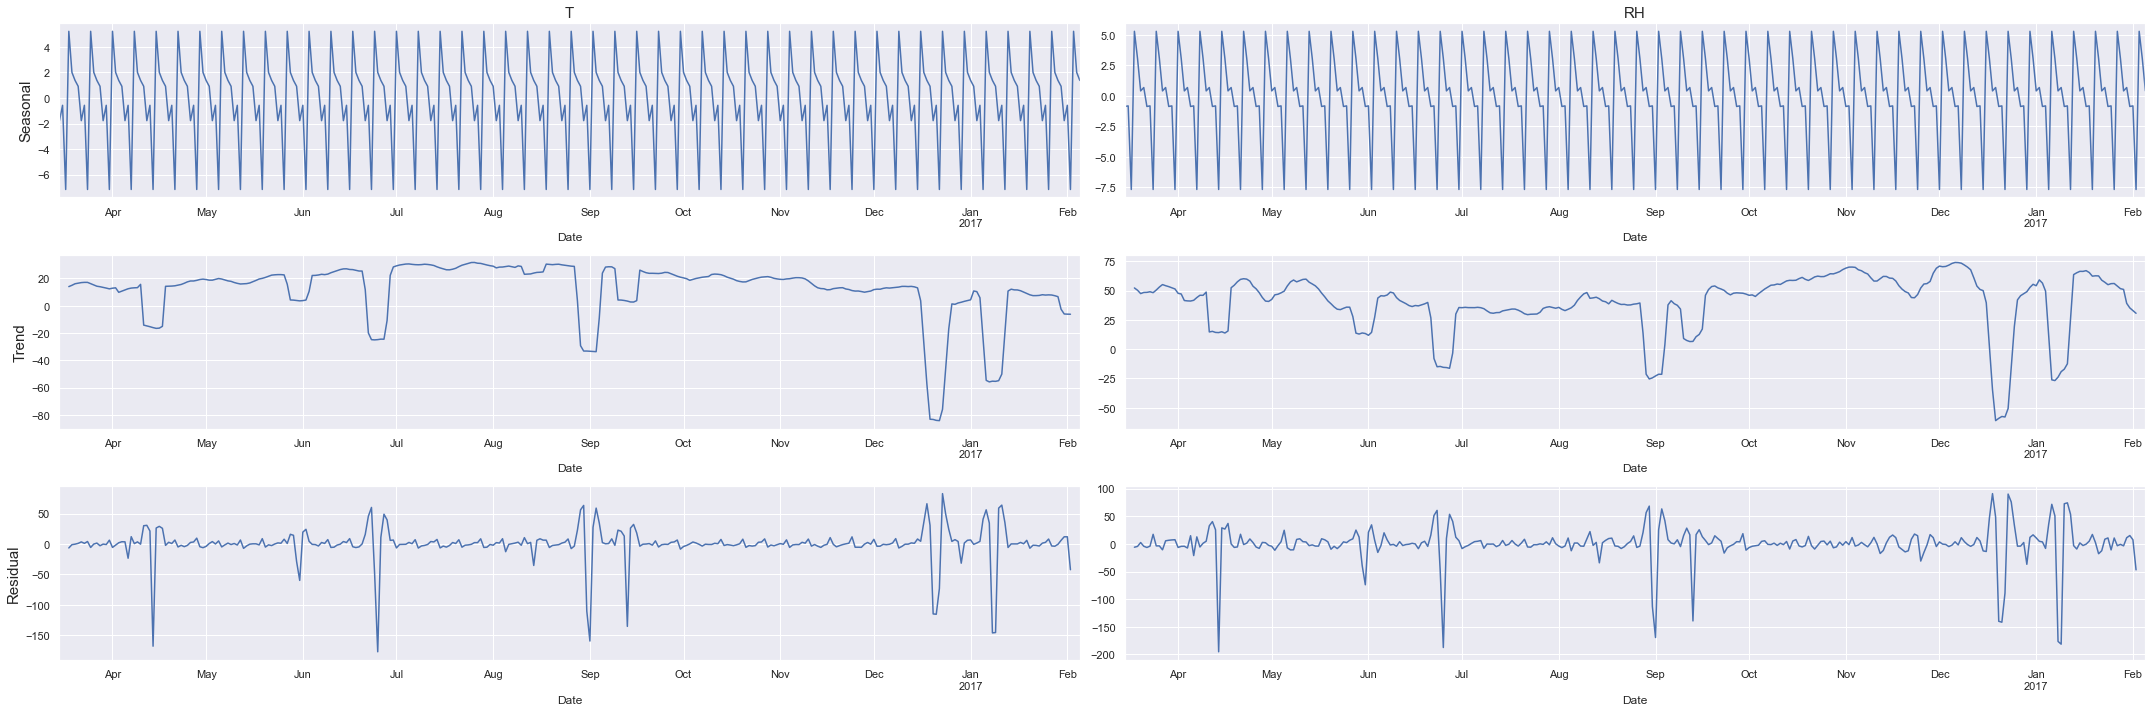

In [27]:
fig7, ax7 = plt.subplots(nrows=3, ncols=2, figsize=(30, 10))

for idx, col in enumerate(pivot_df.columns[-2:]):
    results = seasonal_decompose(pivot_df[col], model='additive') #multiplicative not suitable for dataset as they contain negative values
    results.seasonal.plot(ax=ax7[0, idx])
    results.trend.plot(ax=ax7[1, idx])
    results.resid.plot(ax=ax7[2, idx])

    ax7[0, idx].set_title(col, fontsize=15)
    ax7[0, 0].set_ylabel('Seasonal', fontsize=15)
    ax7[1, 0].set_ylabel('Trend', fontsize=15)
    ax7[2, 0].set_ylabel('Residual', fontsize=15)

plt.tight_layout()
plt.show()

**<u>Observations</u>**

- No linear trend among time series, although values (from first and last dates in time series) seem to be decreasing
- Extreme seasonality in each time series, with patterns occuring every week or 7 days.
- Within each month there are always 4 spike patterns, which are representative of the 4 weeks in every month

## Testing for Stationarity

To check if the time series is stationary and the number of differencing required, unit root tests are performed to check stationarity of a time series.

### What is a Unit Root?

Unit root is a characteristic of a time series that makes it non-stationary. A unit root is said to exist in a time series if the value of $\alpha = 1$ in the below equation:

$$
Y_t = \alpha Y_{t-1} + \beta X_e + \epsilon
$$

where: <br> <br>
$Y_t$ = value of the time series at time $t$  </br>
$X_e$ = an exogenous variable (a separate explanatory variable) </br>

### What does having a Unit Root mean?

The presence of a unit root means the time series is non-stationary. Besides, the number of unit roots contained in the series corresponds to the number of differencing operations required to make the series stationary.

In [28]:
def stationarity_test(df, columns, n_lags='auto', alpha=0.05):
    adf_results = []
    kpss_results = []
    
    for col in columns:
        # Augmented Dicky-Fuller test
        adf_res = list(adfuller(df[col], autolag='AIC', maxlag=n_lags))
        adf_res[1] = adf_res[1]
        del adf_res[3]
        del adf_res[-1]
        adf_crit = list(adf_res[-1].values())[1]
        del adf_res[-1]
        adf_res.append(adf_crit)
    
        if adf_res[1] < alpha:
            # if p-value less than alpha, reject null hypothesis, ts is stationary
            adf_res.append(True)
        else:
            # if p-value greater than alpha, reject null hypothesis, ts is non-stationary
            adf_res.append(False)

        adf_results.append(adf_res)

        # KPSS test
        kpss_res = list(kpss(df[col], regression='c', nlags=n_lags)) # I test for stationarity around a constant.
        kpss_res[1] = kpss_res[1]
        kpss_crit = list(kpss_res[-1].values())[1]
        del kpss_res[-1]
        kpss_res.append(kpss_crit)

        if kpss_res[1] < alpha:
            # if p-value less than alpha, reject null hypothesis, ts is non-stationary
            kpss_res.append(False)
        else:
            # if p-value greater than alpha, reject null hypothesis, ts is stationary
            kpss_res.append(True)

        kpss_results.append(kpss_res)
        
    temp_cols = ['Test Statistic', 'p-value', 'n_lags','5% crit value', 'Stationary']
    adf_df = pd.DataFrame(adf_results, columns=temp_cols, index=columns)
    kpss_df = pd.DataFrame(kpss_results, columns=temp_cols, index=columns)

    return adf_df, kpss_df


In [29]:
adf_results, kpss_results = stationarity_test(pivot_df, pivot_df.columns, 1)

### Dickey-Fuller Test

Before going into Augmented Dickey-Fuller test, it is important to understand what the Dickey-Fuller test is.

A Dickey-Fuller test is a unit root test that tests $H_0: \alpha = 1$ in the following model equation. $\alpha$ is the coefficient of the first lag on $Y$.

$H_0: \alpha = 1$

$H_1: \alpha < 1$

$$
y_t = c + \beta t + \alpha y_{t-1} + \phi\Delta Y_{t-1} + e_t
$$

where: <br><br>
$y_{t-1}$ = lag $1$ of time series  </br>
$\Delta Y_{t-1}$ = First difference of time series at time $t-1$

It has a similar $H_0$ as the unit root test. That is, the coefficient of $Y_{t-1} = 1$, implying the presence of a unit root. <br>
If not rejected, the time series is taken to be non-stationary.

#### Augmented Dicky-Fuller Test

The Augmented Dickey-Fuller test expands the Dickey-Fuller test to include high order regressive process in the model.

$$
Y_t = c + \beta t + \alpha y_{t-1} + \phi_1\Delta Y_{t-1} + \phi_2\Delta Y_{t-2} + ... + \phi_p\Delta Y_{t-p} + e_t
$$

The equation above only includes more differencing terms, while the rest remains the same. $H_0$ still remains the same as the Dickey-Fuller test.

Since $H_0$ assumes the presence of unit root, that is $\alpha = 1$, the p-value obtained should be less than the significance level (for example, 0.05) in order to reject $H_0$. <br> Thereby, inferring that the series is stationary.

$H_0$: Series is not stationary

$H_1$: Series is stationary

In [30]:
display(adf_results)

,Test Statistic,p-value,n_lags,5% crit value,Stationary
Gas,,,,,
CO,-9.543522,2.687004e-16,1,-2.870447,True
HC,-9.668345,1.296923e-16,1,-2.870447,True
NO2,-10.055200,1.378924e-17,1,-2.870447,True
O3,-9.569087,2.314190e-16,1,-2.870447,True
T,-10.250990,4.486315e-18,1,-2.870447,True
RH,-10.245828,4.620610e-18,1,-2.870447,True


**<u>Observations</u>**

- p-value < 5% for all time series. Hence, $H_0$ is rejected at significance level of 5%.
- Based on ADF test, all time series are stationary and do not require differencing.

### Kwiatkowski–Phillips–Schmidt–Shin Test

#### KPSS vs ADF
The KPSS test is another type of Unit root test that tests for the stationarity of a given series around a 'deterministic trend'.

A key difference from ADF test is that the $H_0$ of the KPSS test is that the series is stationary, which means the interpretation of p-value is the opposite to each other.

If p-value < significance level of 0.05, then the series is non-stationary. Whereas in ADF test, it would mean the tested series is stationary.

$H_0$: Series is stationary

$H_1$: Series is not stationary

> <span style="color:red">**Cautions**</span>: A major disadvantage for the KPSS test is that it has a high rate of Type I errors (tends to reject $H_0$ too often) even if a series is steadily increasing/decreasing.

One way to deal with the potential for high Type I errors is to combine the KPSS with an ADF test. If the result from both tests suggests that the time series in stationary, then it probably is.

In [31]:
display(kpss_results)

,Test Statistic,p-value,n_lags,5% crit value,Stationary
Gas,,,,,
CO,0.353745,0.097093,1,0.463,True
HC,0.275775,0.100000,1,0.463,True
NO2,2.212314,0.010000,1,0.463,False
O3,0.541429,0.032336,1,0.463,False
T,0.866575,0.010000,1,0.463,False
RH,0.181227,0.100000,1,0.463,True


**<u>Observations</u>**

- `CO`, `HC`, `RH` have p-values < 5%. Hence $H_0$ is not rejected at significance level of 5%.
- However, `NO2`, `O3`, and `T`  has a p-value > 5%, meaning $H_0$ is rejected at significance level of 5%.
- Considering the KPSS test's high rate of Type 1 errors, and the results of ADF and KPSS tests, I conclude that the time series are stationary and does not need differencing.

## Cointegration Test

A cointegration test is used to establish if there is a correlation between several time series in the long term. The concept was first introduced by Nobel laureates Robert Engle and Clive Granger in 1987 after British economist Paul Newbold and Granger published the spurious regression concept.

I will be conducting these tests:
- Johansen's Cointegration Test (using trace/maximum eigenvalue)
- Engle Granger Cointegration Test

<!-- [Cointegration](#https://corporatefinanceinstitute.com/resources/knowledge/other/cointegration/#:~:text=A%20cointegration%20test%20is%20used,published%20the%20spurious%20regression%20concept.)

[Johansen's Test](#https://www.statisticshowto.com/johansens-test/)

[Engle Granger Test](#https://www.statisticshowto.com/engle-granger-test/)

https://quantra.quantinsti.com/questionDetails/713/Johansen-test-lagged-difference-terms -->

### Johansen's Test

In [32]:
# Johansen’s test treats every test variable as endogenous variables
# 0 det_order as time series do appear to have seasonal patterns.
# lagged difference of 1 to reduce overfitting
jt_results = coint_johansen(endog=pivot_df, det_order=0, k_ar_diff=1)

#### Trace Test

Trace tests evaluate the number of linear combinations in a time series data, i.e., $K$ = $K_0$, and the hypothesis for the value $K$ > $K_0$.

When using the trace test to test for cointegration in a sample, $K_0$ is set to zero to test whether $H_0$ will be rejected. If it is rejected, we can deduce that there exists a cointegration relationship in the sample. Therefore, $H_0$ should be rejected to confirm the existence of a cointegration relationship in the sample.

$H_0$: $K$ = $K_0$ (No cointegration exists)

$H_1$: $K$ > $K_0$ (Cointegration exists)  

In [33]:
trace = jt_results.lr1 # trace statistic
crit_vals = jt_results.cvt[:, 1] # 5% alpha

for col, trc, val in zip(pivot_df.columns, trace, crit_vals):
    condition = (trc == val)
    
    if condition:
        print(f'{col}: Failed to reject H0. No cointegration.')
    else:
        print(f'{col}: Reject H0. Cointegration exists.')

CO: Reject H0. Cointegration exists.
HC: Reject H0. Cointegration exists.
NO2: Reject H0. Cointegration exists.
O3: Reject H0. Cointegration exists.
T: Reject H0. Cointegration exists.
RH: Reject H0. Cointegration exists.


**<u>Observations</u>**

- Results from Johansen's test appear to suggest that cointegration is present is all time series

### Engle Granger Test

The Engle Granger test is a test for cointegration. It constructs residuals  based on the static regression. The test uses the residuals to see if unit roots are present, using Augmented Dickey-Fuller test or another, similar test. The residuals will be practically stationary if the time series is cointegrated.

If the pvalue is small, below a critical size, then we can reject the hypothesis that there is no cointegrating relationship.

$H_0$: No cointegration exists

$H_1$: Cointegration exists

In [34]:
for col in pivot_df.columns:
    t_stat, p_val, cvt = coint(y0=pivot_df[col], y1=pivot_df.drop([col], axis=1), trend='c', method='aeg')
    if p_val < 0.05:
        print(f'{col}: Reject H0. Cointegration exists.')
    else:
        print(f'{col}: Failed to reject H0. No cointegration.')

CO: Failed to reject H0. No cointegration.
HC: Failed to reject H0. No cointegration.
NO2: Failed to reject H0. No cointegration.
O3: Failed to reject H0. No cointegration.
T: Failed to reject H0. No cointegration.
RH: Reject H0. Cointegration exists.


**<u>Observations</u>**

- The Engle Granger test results suggests that at least 1 time series is cointegrated.
- Based results from both cointegration tests, I can conclude that there apppears to be some cointegration between time series.

## Endogenous and Exogneous Variables

Because I will be modelling with both univariate and multivariate forecasting models, it is important to define the dependent and independent / endogenous and exogenous time series

In [35]:
# Endogenous varaibles are dependent(y), while exogenous variables are independent(X).
endog, exog = pivot_df[gases], pivot_df.drop(gases, axis=1)

## Model Selection

### Expanding Window Cross Validation

An unbiased model evaluation technique is crucial for us to understand the general potential of the model. One way to achieve it is through training and evaluating the model multiple time each with different window of dataset.

This is where Expanding Window technique comes into play as illustrated below

![](https://i.imgur.com/AJjGCnu.png)


Hence, moving forward, I will be using Expanding Window Cross Validation.

<!-- [Cross Validation in Time Series](#https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4)

[Build evaluation framework for forecasst models](#https://towardsdatascience.com/build-evaluation-framework-for-forecast-models-fbc1bd775edd)

[A guide to different evaluation metrics for time series](#https://analyticsindiamag.com/a-guide-to-different-evaluation-metrics-for-time-series-forecasting-models/) -->

Because the size of the test data from Kaggle contains 63 rows, I will be using that information to create a hold out set with the same length and splitting our data into train and hold out splits.

In [36]:
TEST_SIZE = 63
endog_train, endog_test = endog[:-TEST_SIZE], endog[-TEST_SIZE:]
exog_train, exog_test = exog[:-TEST_SIZE], exog[-TEST_SIZE:]

In [59]:
def tscv(model, endog, order_dict, seasonal_orders=None, test_size=TEST_SIZE, splits=3, exog=None, **kwargs):
    results = {}

    for gas, order in order_dict.items():
        cv = TimeSeriesSplit(test_size=test_size, n_splits=splits)
        mse_score = []
        rmse_score = []
        mae_score = []
        mape_score = []
        aic = []

        # from original train set, split into train and validation sets 
        for train_idx, test_idx in cv.split(endog[gas].iloc[:-test_size]):
            cv_train, cv_test = endog[gas].iloc[train_idx], endog[gas].iloc[test_idx]
            true_values = cv_test.values

            if seasonal_orders is not None:
                sarimax = model(cv_train, exog.iloc[train_idx], order=order, seasonal_order=seasonal_orders[gas], freq='D', **kwargs).fit()
                pred = sarimax.predict(start=cv_test.index.values[0], end=cv_test.index.values[-1], exog=exog.iloc[test_idx])
                mse_score.append(mse(true_values, pred))
                rmse_score.append(rmse(true_values, pred))
                mae_score.append(meanabs(true_values, pred))
                mape_score.append(meanabs(true_values, pred) / len(true_values))
                aic.append(sarimax.aic)

                results.update({f'{gas} {order} {seasonal_orders[gas]}': [np.mean(mse_score), np.mean(rmse_score), np.mean(mae_score), np.mean(mape_score), np.mean(aic)]})

            if (exog is not None) and (seasonal_orders is None):
                arma = model(cv_train, exog.iloc[train_idx], order=order, freq='D', **kwargs).fit()
                pred = arma.predict(start=cv_test.index.values[0], end=cv_test.index.values[-1], exog=exog.iloc[test_idx])
                mse_score.append(mse(true_values, pred))
                rmse_score.append(rmse(true_values, pred))
                mae_score.append(meanabs(true_values, pred))
                mape_score.append(meanabs(true_values, pred) / len(true_values))
                aic.append(arma.aic)

                results.update({f'{gas} {order}': [np.mean(mse_score), np.mean(rmse_score), np.mean(mae_score), np.mean(mape_score), np.mean(aic)]})
            elif (exog is None) and (seasonal_orders is None):
                arma = model(cv_train, order=order, freq='D', **kwargs).fit()
                pred = arma.predict(start=cv_test.index.values[0], end=cv_test.index.values[-1])
                mse_score.append(mse(true_values, pred))
                rmse_score.append(rmse(true_values, pred))
                mae_score.append(meanabs(true_values, pred))
                mape_score.append(meanabs(true_values, pred) / len(true_values))
                aic.append(arma.aic)

                results.update({f'{gas} {order}': [np.mean(mse_score), np.mean(rmse_score), np.mean(mae_score), np.mean(mape_score), np.mean(aic)]})
    
    return pd.DataFrame.from_dict(results, orient='index', columns=['MSE', 'RMSE', 'MAE', 'MAPE', 'AIC']) 

def evaluate_models(model, df, var, p_values, d_values, q_values, P_values=None, D_values=None, Q_values=None, m_values=None, **kwargs):
    temp_dict = {}

    count = 1

    model_name = list(model.keys())[0]
    model = list(model.values())[0]
    # If P is defined, I assumed the rest of seasonal orders are defined.
    # SARIMAX evaluation
    if P_values is not None:
        for p in p_values:
            for d in d_values:
                for q in q_values:
                    for P in P_values:
                        for D in D_values:
                            for Q in Q_values:
                                for m in m_values:
                                    try:
                                        order = (p,d,q)
                                        s_order = {var : (P, D, Q, m)}
                                        # print(order, s_order)
                                        results = tscv(model, df, order_dict={var : order}, seasonal_orders=s_order, **kwargs)
                                        rmse_ = round(results['RMSE'].values[0], 4)
                                        mape = round(results['MAPE'].values[0], 4)
                                        aic = round(results['AIC'].values[0], 4)

                                        print(f'Iteration {count}\t\t{order} {s_order[var]}\t\tRMSE: {rmse_}\t\tAIC: {aic}')
                                        count += 1
                                        
                                        temp_dict.update({f'{order} {s_order[var]}' : [rmse_, mape, aic]})
                                    except:
                                        continue
    # ARMA / ARMAX Evaluation
    else:
        for p in p_values:
            for d in d_values:
                for q in q_values:
                    order = (p,d,q)
                    try:
                        results = tscv(model, df, order_dict={var : order}, **kwargs)
                        rmse_ = round(results['RMSE'].values[0], 4)
                        mape = round(results['MAPE'].values[0], 4)
                        aic = round(results['AIC'].values[0], 4)
                        
                        print(f'Iteration {count} {order}\t\tRMSE: {rmse_}\t\tAIC: {aic}')
                        count += 1

                        temp_dict.update({order : [rmse_, mape, aic]})
                    except:
                        continue
                       
    results_df = pd.DataFrame.from_dict(temp_dict, orient='index', columns=['RMSE', 'MAPE', 'AIC']).rename_axis(model_name, axis=0)
    return results_df

## Univariate Time Series Forecasting

### **ARMA** 

I would like to see if using past pollution values can accurately forecast future values by treating the dataset as a univariate time series, ignoring the exogenous variables. Hence, I will be using ARMA as a baseline model for comparison.

#### Finding Optimal Order

<!-- [Find the order of ARIMA models](#https://towardsdatascience.com/find-the-order-of-arima-models-b4d99d474e7a) -->

<!-- ##### ACF and PACF Plots

[Significance of ACF and PACF Plots In Time Series Analysis](#https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8#:~:text=A%20time%20series%20can%20have,a%20partial%20auto%2Dcorrelation%20function.) <br>

[Time Series Analysis: Identifying AR and MA using ACF and PACF Plots](#https://towardsdatascience.com/identifying-ar-and-ma-terms-using-acf-and-pacf-plots-in-time-series-forecasting-ccb9fd073db8)

https://towardsdatascience.com/find-the-order-of-arima-models-b4d99d474e7a -->

When using an ARMA model to forecast, we have to choose an order. the AR($p$) component of represents the changing variable that regresses on its prior values and the MA($q$) component represents the changing variable that depends on its lagged forecast errors.

To find the optimal AR and MA orders for our ARMA model, we will make use of ACF and PACF plots. 

The auto-correlation function gives us values of auto-correlation of any series with its lagged values. It describes how well the present value of the series is related with its past values. 

The partial auto-correlation function instead of finding correlations of present with lags like ACF, it finds correlation of the residuals with the next lag value hence partial and not complete as found variations are removed before finding the next correlation. 

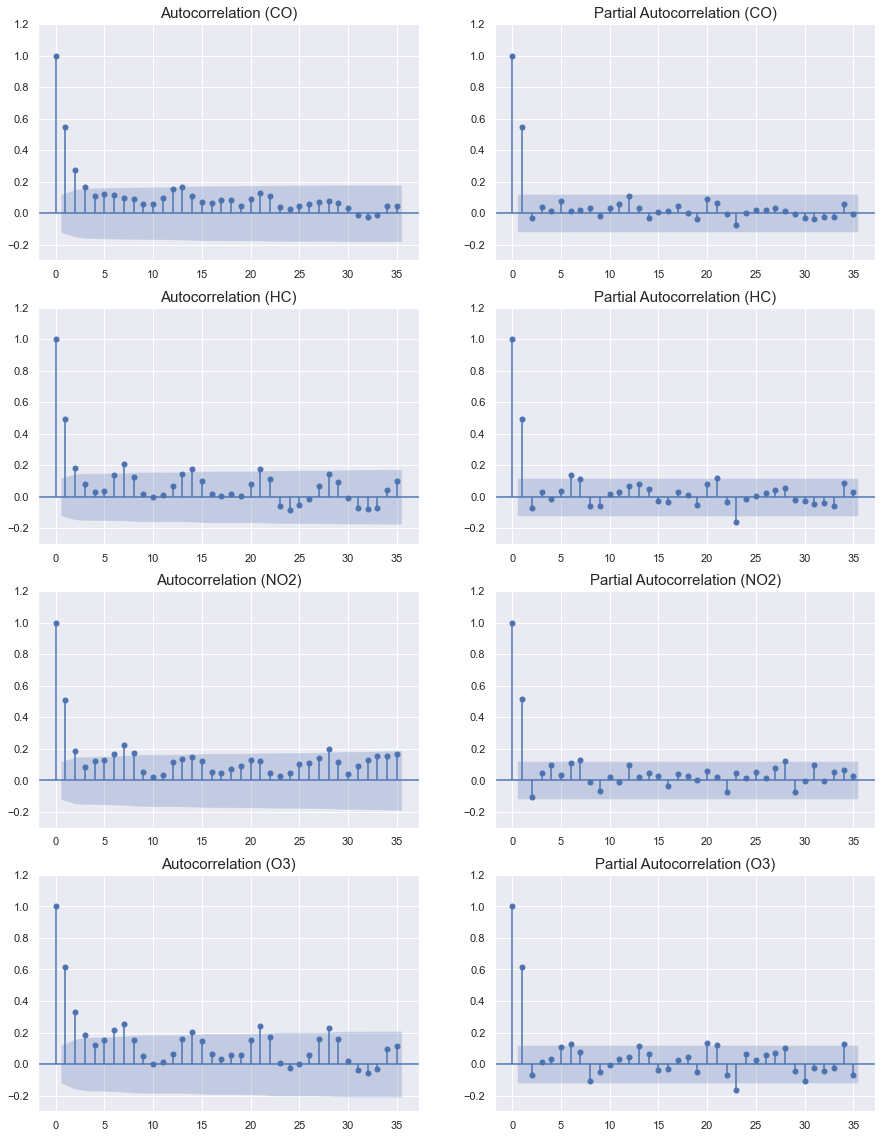

In [52]:
# ACF &  PACF plots
fig6, axes6 = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

for idx, gas in enumerate(gases):
    plot_acf(endog_train[gas], ax=axes6[idx, 0], lags=35, alpha=0.05)
    plot_pacf(endog_train[gas], ax=axes6[idx, 1], lags=35, alpha=0.05)

    axes6[idx, 0].set_title(f'Autocorrelation ({gas})', fontsize=15)
    axes6[idx, 1].set_title(f'Partial Autocorrelation ({gas})', fontsize=15)
    
    axes6[idx, 0].set_ylim(top=1.2, bottom=-.3)
    axes6[idx, 1].set_ylim(top=1.2, bottom=-.3)

plt.show()

- Based off my interpretation of each ACF and PACF plot, these are the orders I deemed suitable:

|     Gas      |      AR($p$)      |      MA($q$)      | 
|:------------:|:-----------------:|:-----------------:|
|      CO      |         1         |         0         |
|      HC      |         1         |         8         |
|      NO2     |         1         |         8         |
|      O3      |         1         |         7         |


- I choose the orders by inferring from the ACF and PACF plots to find the most significant lags.

In [53]:
# Baseline ARMA Performance
arma_orders = {
    'CO': (1, 0, 0),
    'HC': (1, 0, 8),
    'NO2': (1, 0, 8),
    'O3': (1, 0, 7),
}

tscv(ARIMA, endog_train, order_dict=arma_orders)

,MSE,RMSE,MAE,MAPE,AIC
"CO (1, 0, 0)",41820.991667,204.437175,127.626545,2.025818,969.933310
"HC (1, 0, 8)",28348.922041,167.707112,107.097587,1.699962,970.490848
"NO2 (1, 0, 8)",31397.929389,177.039672,118.705914,1.884221,976.276651
"O3 (1, 0, 7)",54647.334850,233.041028,171.518041,2.722509,1011.503600


### Hyperparameter Tuning: ARMA

I will be fitting different models for each gas type and perform hyperparameter tuning independently, using the Expanding Window Cross Validation and evaluating my forecast model's performance based on the lowest Aikeike Information Criteria (AIC) and Root Mean Squared Error(RMSE).

As we are comparing different models I will pay more focus on the AIC values as it tells us how well the model fit our data.

In [54]:
arma = {'ARMA' : ARIMA}

p_range = np.arange(5)
q_range = np.arange(5)
d_range = [0 for i in range(1)]

#### CO

In [55]:
co_arma_res = evaluate_models(arma, df=endog_train, var='CO', p_values=p_range, d_values=d_range, q_values=q_range)

Iteration 1 (0, 0, 0)		RMSE: 209.9035		AIC: 985.5999
Iteration 2 (0, 0, 1)		RMSE: 208.373		AIC: 973.8238
Iteration 3 (0, 0, 2)		RMSE: 206.9236		AIC: 971.8498
Iteration 4 (0, 0, 3)		RMSE: 205.7206		AIC: 971.8328
Iteration 5 (0, 0, 4)		RMSE: 205.8504		AIC: 973.8121
Iteration 6 (1, 0, 0)		RMSE: 204.4372		AIC: 969.9333
Iteration 7 (1, 0, 1)		RMSE: 204.2599		AIC: 971.4224
Iteration 8 (1, 0, 2)		RMSE: 208.3684		AIC: 973.3558
Iteration 9 (1, 0, 3)		RMSE: 207.9962		AIC: 974.0555
Iteration 10 (1, 0, 4)		RMSE: 207.2232		AIC: 975.0268
Iteration 11 (2, 0, 0)		RMSE: 204.2074		AIC: 971.2438
Iteration 12 (2, 0, 1)		RMSE: 204.0972		AIC: 973.2368
Iteration 13 (2, 0, 2)		RMSE: 207.5609		AIC: 973.4812
Iteration 14 (2, 0, 3)		RMSE: 207.8531		AIC: 975.9178
Iteration 15 (2, 0, 4)		RMSE: 207.3038		AIC: 976.8724
Iteration 16 (3, 0, 0)		RMSE: 205.5824		AIC: 973.1136
Iteration 17 (3, 0, 1)		RMSE: 208.4188		AIC: 974.1835
Iteration 18 (3, 0, 2)		RMSE: 207.2765		AIC: 974.5181
Iteration 19 (3, 0, 3)		RMSE: 207.5384

In [56]:
co_arma_res.sort_values('AIC').head().style.apply(lambda x: ['background-color: green; color: white' if v else '' for v in x == x.min()])

,RMSE,MAPE,AIC
ARMA,,,
"(1, 0, 0)",204.437200,2.025800,969.933300
"(2, 0, 0)",204.207400,2.022400,971.243800
"(1, 0, 1)",204.259900,2.022100,971.422400
"(0, 0, 3)",205.720600,2.050800,971.832800
"(0, 0, 2)",206.923600,2.078200,971.849800


#### HC

In [57]:
hc_arma_res = evaluate_models(arma, df=endog_train, var='HC', p_values=p_range, d_values=d_range, q_values=q_range)

Iteration 1 (0, 0, 0)		RMSE: 168.5296		AIC: 968.8401
Iteration 2 (0, 0, 1)		RMSE: 168.2286		AIC: 961.2259
Iteration 3 (0, 0, 2)		RMSE: 167.7625		AIC: 962.2935
Iteration 4 (0, 0, 3)		RMSE: 166.2741		AIC: 962.4595
Iteration 5 (0, 0, 4)		RMSE: 166.2559		AIC: 963.9523
Iteration 6 (1, 0, 0)		RMSE: 167.3408		AIC: 961.1157
Iteration 7 (1, 0, 1)		RMSE: 167.1678		AIC: 962.2685
Iteration 8 (1, 0, 2)		RMSE: 165.4185		AIC: 963.3768
Iteration 9 (1, 0, 3)		RMSE: 167.2376		AIC: 963.3428
Iteration 10 (1, 0, 4)		RMSE: 167.3883		AIC: 964.8736
Iteration 11 (2, 0, 0)		RMSE: 167.03		AIC: 961.9983
Iteration 12 (2, 0, 1)		RMSE: 166.9889		AIC: 963.6769
Iteration 13 (2, 0, 2)		RMSE: 173.916		AIC: 961.6632
Iteration 14 (2, 0, 3)		RMSE: 168.8693		AIC: 961.8563
Iteration 15 (2, 0, 4)		RMSE: 172.8272		AIC: 960.689
Iteration 16 (3, 0, 0)		RMSE: 167.5288		AIC: 963.7468
Iteration 17 (3, 0, 1)		RMSE: 170.2487		AIC: 964.0223
Iteration 18 (3, 0, 2)		RMSE: 174.5151		AIC: 960.2253
Iteration 19 (3, 0, 3)		RMSE: 175.5719		A

In [58]:
hc_arma_res.sort_values('AIC').head().style.apply(lambda x: ['background-color: green; color: white' if v else '' for v in x == x.min()])

,RMSE,MAPE,AIC
ARMA,,,
"(3, 0, 2)",174.515100,1.709400,960.225300
"(2, 0, 4)",172.827200,1.681400,960.689000
"(1, 0, 0)",167.340800,1.698000,961.115700
"(0, 0, 1)",168.228600,1.713300,961.225900
"(2, 0, 2)",173.916000,1.756600,961.663200


#### NO2

In [59]:
no2_arma_res = evaluate_models(arma, df=endog_train, var='NO2', p_values=p_range, d_values=d_range, q_values=q_range)

Iteration 1 (0, 0, 0)		RMSE: 177.5314		AIC: 980.5599
Iteration 2 (0, 0, 1)		RMSE: 178.6142		AIC: 966.8134
Iteration 3 (0, 0, 2)		RMSE: 178.9205		AIC: 967.959
Iteration 4 (0, 0, 3)		RMSE: 180.8093		AIC: 967.1475
Iteration 5 (0, 0, 4)		RMSE: 180.3522		AIC: 968.8895
Iteration 6 (1, 0, 0)		RMSE: 181.6342		AIC: 967.5766
Iteration 7 (1, 0, 1)		RMSE: 180.8879		AIC: 967.7829
Iteration 8 (1, 0, 2)		RMSE: 181.923		AIC: 968.1437
Iteration 9 (1, 0, 3)		RMSE: 177.7587		AIC: 969.101
Iteration 10 (1, 0, 4)		RMSE: 177.6907		AIC: 970.227
Iteration 11 (2, 0, 0)		RMSE: 180.3922		AIC: 966.9532
Iteration 12 (2, 0, 1)		RMSE: 181.0827		AIC: 968.4143
Iteration 13 (2, 0, 2)		RMSE: 180.7066		AIC: 969.081
Iteration 14 (2, 0, 3)		RMSE: 176.9246		AIC: 970.0251
Iteration 15 (2, 0, 4)		RMSE: 176.5689		AIC: 971.1243
Iteration 16 (3, 0, 0)		RMSE: 179.1465		AIC: 968.1966
Iteration 17 (3, 0, 1)		RMSE: 176.6258		AIC: 968.206
Iteration 18 (3, 0, 2)		RMSE: 175.1856		AIC: 970.4599
Iteration 19 (3, 0, 3)		RMSE: 182.0476		AIC

In [60]:
no2_arma_res.sort_values('AIC').head().style.apply(lambda x: ['background-color: green; color: white' if v else '' for v in x == x.min()])

,RMSE,MAPE,AIC
ARMA,,,
"(0, 0, 1)",178.614200,1.920500,966.813400
"(2, 0, 0)",180.392200,1.955600,966.953200
"(0, 0, 3)",180.809300,1.963000,967.147500
"(1, 0, 0)",181.634200,1.973700,967.576600
"(1, 0, 1)",180.887900,1.962400,967.782900


#### O3

In [61]:
o3_arma_res = evaluate_models(arma, df=endog_train, var='O3', p_values=p_range, d_values=d_range, q_values=q_range)

Iteration 1 (0, 0, 0)		RMSE: 233.376		AIC: 1024.867
Iteration 2 (0, 0, 1)		RMSE: 231.3944		AIC: 1008.0532
Iteration 3 (0, 0, 2)		RMSE: 228.1237		AIC: 1006.4492
Iteration 4 (0, 0, 3)		RMSE: 225.8564		AIC: 1005.9777
Iteration 5 (0, 0, 4)		RMSE: 230.3009		AIC: 1007.0266
Iteration 6 (1, 0, 0)		RMSE: 223.1741		AIC: 1005.542
Iteration 7 (1, 0, 1)		RMSE: 224.5534		AIC: 1006.7981
Iteration 8 (1, 0, 2)		RMSE: 223.3146		AIC: 1007.5703
Iteration 9 (1, 0, 3)		RMSE: 230.4515		AIC: 1007.1595
Iteration 10 (1, 0, 4)		RMSE: 226.1483		AIC: 1008.0178
Iteration 11 (2, 0, 0)		RMSE: 226.1967		AIC: 1006.4627
Iteration 12 (2, 0, 1)		RMSE: 223.1052		AIC: 1007.8579
Iteration 13 (2, 0, 2)		RMSE: 246.828		AIC: 1004.853
Iteration 14 (2, 0, 3)		RMSE: 230.4836		AIC: 1004.7202
Iteration 15 (2, 0, 4)		RMSE: 252.6906		AIC: 1001.8773
Iteration 16 (3, 0, 0)		RMSE: 233.182		AIC: 1007.0331
Iteration 17 (3, 0, 1)		RMSE: 245.3442		AIC: 1006.6123
Iteration 18 (3, 0, 2)		RMSE: 252.815		AIC: 999.7613
Iteration 19 (3, 0, 3)		RMS

In [62]:
o3_arma_res.sort_values('AIC').head().style.apply(lambda x: ['background-color: green; color: white' if v else '' for v in x == x.min()])

,RMSE,MAPE,AIC
ARMA,,,
"(3, 0, 2)",252.815000,3.007500,999.761300
"(2, 0, 4)",252.690600,3.025700,1001.877300
"(4, 0, 1)",250.902100,2.989900,1003.758800
"(3, 0, 3)",254.276600,2.998200,1003.945800
"(4, 0, 0)",245.460100,2.904200,1004.094700


### Summary of ARMA CV Results

|  Gas  |  AR($p$)  |   MA($q$)   |       RMSE      |       AIC       |   Baseline RMSE   |     Baseline AIC    |
|:-----:|:---------:|:-----------:|:---------------:|:---------------:|:-----------------:|:-------------------:| 
|  CO   |     1     |     1       |   163.843300	|    884.062800   |     162.449441    |     886.380866      | 	
|  HC   |     2     |     4       |   136.919400    |    881.442900   |     128.991442    |     891.356064      |  
|  NO2  |     2     |     0       |   148.364600    |    907.775900   |     143.686872    |     912.834783      |	
|  O3   |     2     |     4       |   215.003700    |    960.948200   |     195.366063    |     971.850295      | 

Based on the cross-validated results, it seems that a a tuned ARMA model is not able able to perform better than the average baseline. However, our results do show lower AIC values indicating a better fit to our data.

#### Visualising ARMA Forecasts

By plotting and visualising our model's predictions we can see how well our model is doing.

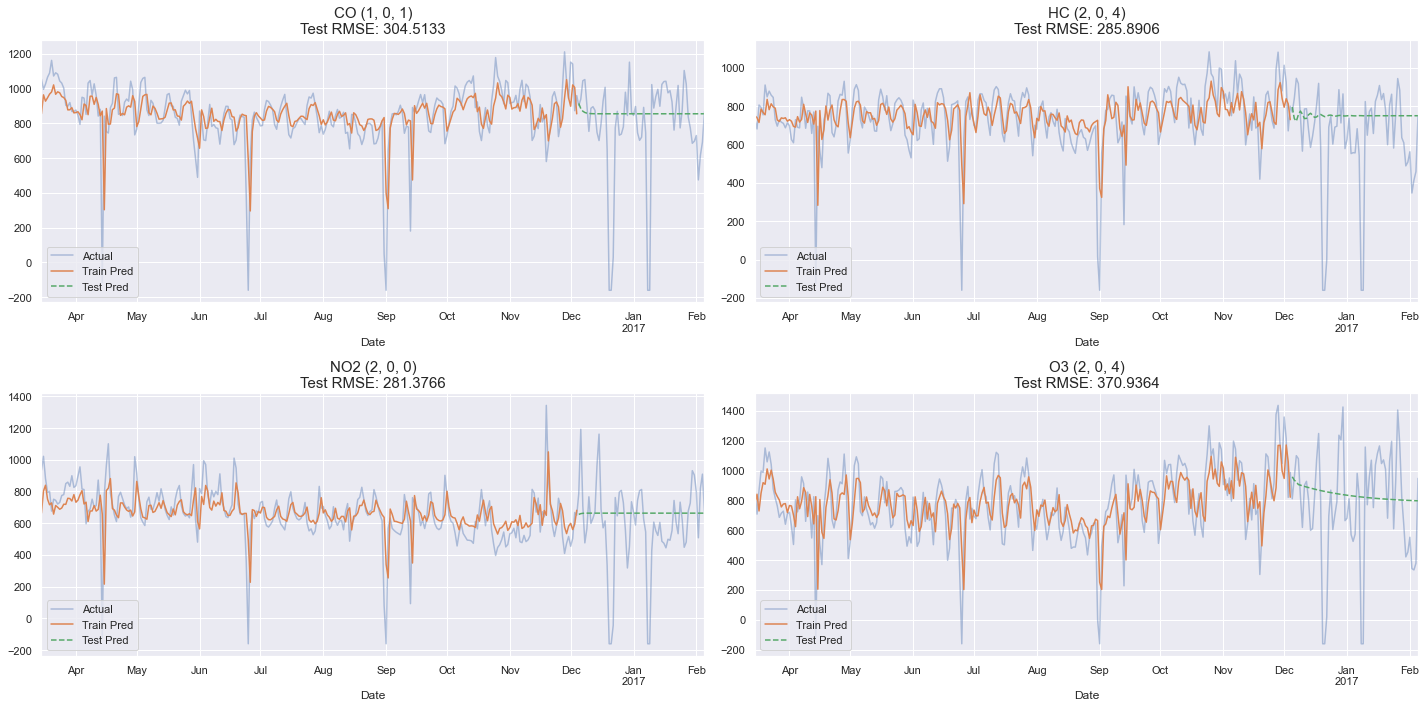

In [63]:
arma_optimal_orders = [
    ('CO', (1, 0, 1)),
    ('HC', (2, 0, 4)),
    ('NO2', (2, 0, 0)),
    ('O3', (2, 0, 4))
]

arma_summary = {}

fig7, ax7 = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

for ax, (var, order) in zip(ax7.flatten(), arma_optimal_orders):
    model = ARIMA(endog_train[var], order=order).fit()
    train_pred = model.predict(start=0, end=-1)
    test_pred = model.forecast(TEST_SIZE)

    # RMSE of validation set 
    rmse_ = round(rmse(endog_test[var], test_pred), 4)

    endog[var].plot(ax=ax, label='Actual', alpha=0.4)
    train_pred.plot(ax=ax, label='Train Pred')
    test_pred.plot(ax=ax, label='Test Pred', linestyle='--')

    ax.legend(loc='lower left')
    ax.set_title(f'{var} {order}\nTest RMSE: {rmse_}', fontsize=15)

    arma_summary.update({var : model.summary()})

plt.tight_layout()
plt.show()

**<u>Observations</u>**

- Our ARMA models for `CO`, `HC` , and `NO2` appear to be centered around the mean of each time series, which is why our forecasts appear as a straight line.
- The ARMA model for `O3` appears to be predicting a decreaseing trend.
- Hence, I realised that may be that ARMA models may not be the best forecasting technique for our dataset.

In [64]:
arma_summary['CO']

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     CO   No. Observations:                  265
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1694.184
Date:                Fri, 12 Aug 2022   AIC                           3396.367
Time:                        14:33:28   BIC                           3410.686
Sample:                    03-15-2016   HQIC                          3402.120
                         - 12-04-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        854.4991     28.684     29.790      0.000     798.279     910.719
ar.L1          0.5000      0.101      4.953      0.000       0.302       0.698
ma.L1          0.0686      0.109      0.630      0.529      -0.145       0.282
sigma2      2.088e+04    824.486     25.323      0.000    1.93e+04    2.25e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2866.30
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                            -2.55
Prob(H) (two-sided):                  0.12   Kurtosis:                        18.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
arma_summary['HC']

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     HC   No. Observations:                  265
Model:                 ARIMA(2, 0, 4)   Log Likelihood               -1682.703
Date:                Fri, 12 Aug 2022   AIC                           3381.406
Time:                        14:33:28   BIC                           3410.044
Sample:                    03-15-2016   HQIC                          3392.912
                         - 12-04-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        750.6634     21.447     35.002      0.000     708.629     792.698
ar.L1          0.4920      0.264      1.866      0.062      -0.025       1.009
ar.L2         -0.7742      0.203     -3.821      0.000      -1.171      -0.377
ma.L1          0.0328      0.265      0.124      0.901      -0.487       0.552
ma.L2          0.7265      0.206      3.521      0.000       0.322       1.131
ma.L3          0.4180      0.088      4.741      0.000       0.245       0.591
ma.L4          0.1085      0.114      0.949      0.342      -0.115       0.332
sigma2      1.915e+04    840.336     22.783      0.000    1.75e+04    2.08e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1649.84
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -2.17
Prob(H) (two-sided):                  0.89   Kurtosis:                        14.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
arma_summary['NO2']

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    NO2   No. Observations:                  265
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1689.454
Date:                Fri, 12 Aug 2022   AIC                           3386.908
Time:                        14:33:28   BIC                           3401.227
Sample:                    03-15-2016   HQIC                          3392.661
                         - 12-04-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        663.4830     18.676     35.525      0.000     626.878     700.088
ar.L1          0.5650      0.033     17.012      0.000       0.500       0.630
ar.L2         -0.0977      0.069     -1.418      0.156      -0.233       0.037
sigma2      2.016e+04    808.518     24.939      0.000    1.86e+04    2.17e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               842.08
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.51
Prob(H) (two-sided):                  0.50   Kurtosis:                        11.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [67]:
arma_summary['O3']

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     O3   No. Observations:                  265
Model:                 ARIMA(2, 0, 4)   Log Likelihood               -1751.581
Date:                Fri, 12 Aug 2022   AIC                           3519.162
Time:                        14:33:29   BIC                           3547.800
Sample:                    03-15-2016   HQIC                          3530.668
                         - 12-04-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        782.5587     56.398     13.876      0.000     672.021     893.097
ar.L1          0.9274      1.030      0.900      0.368      -1.091       2.946
ar.L2          0.0357      0.975      0.037      0.971      -1.875       1.946
ma.L1         -0.2870      1.032     -0.278      0.781      -2.310       1.736
ma.L2         -0.3038      0.342     -0.887      0.375      -0.975       0.367
ma.L3         -0.1520      0.321     -0.473      0.636      -0.782       0.478
ma.L4         -0.0822      0.155     -0.532      0.595      -0.385       0.221
sigma2      3.216e+04   2002.389     16.060      0.000    2.82e+04    3.61e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               181.25
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.81
Prob(H) (two-sided):                  0.62   Kurtosis:                         6.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Multivariate Time Series Forecasting

### **ARMAX**

ARMAX stands for Auto Regressive Moving Average with eXogenous variables.

By treating our time series as multivariate, and assuming that pollution values depend on other factors like temperature and humidity, I would like to investigate if forecasts will improve over the baseline.

<!-- I would like to see if using past pollution values can accurately forecast future values by treating the dataset as a univariate time series, ignoring the exogenous variables. Hence, I will be using ARMA as a baseline model for comparison. -->

### Hyperparameter Tuning: ARMAX

In [69]:
armax = {'ARMAX' : ARIMA}

#### CO

In [70]:
co_armax_res = evaluate_models(armax, df=endog_train, exog=exog_train, var='CO', p_values=p_range, d_values=d_range, q_values=q_range)

Iteration 1 (0, 0, 0)		RMSE: 132.5959		AIC: 914.29
Iteration 2 (0, 0, 1)		RMSE: 147.0351		AIC: 871.1528
Iteration 3 (0, 0, 2)		RMSE: 175.9843		AIC: 863.5357
Iteration 4 (0, 0, 3)		RMSE: 159.4556		AIC: 860.442
Iteration 5 (0, 0, 4)		RMSE: 140.7404		AIC: 862.2475
Iteration 6 (1, 0, 0)		RMSE: 181.2037		AIC: 861.9106
Iteration 7 (1, 0, 1)		RMSE: 191.4509		AIC: 859.4023
Iteration 8 (1, 0, 2)		RMSE: 239.584		AIC: 860.1778
Iteration 9 (1, 0, 3)		RMSE: 135.5655		AIC: 862.3792
Iteration 10 (1, 0, 4)		RMSE: 132.6869		AIC: 861.5578
Iteration 11 (2, 0, 0)		RMSE: 194.3023		AIC: 859.9169
Iteration 12 (2, 0, 1)		RMSE: 196.706		AIC: 861.3255
Iteration 13 (2, 0, 2)		RMSE: 143.8977		AIC: 860.0449
Iteration 14 (2, 0, 3)		RMSE: 130.0466		AIC: 864.8562
Iteration 15 (2, 0, 4)		RMSE: 132.7494		AIC: 865.6152
Iteration 16 (3, 0, 0)		RMSE: 195.6567		AIC: 861.3159
Iteration 17 (3, 0, 1)		RMSE: 135.5686		AIC: 862.6686
Iteration 18 (3, 0, 2)		RMSE: 127.2629		AIC: 865.1868
Iteration 19 (3, 0, 3)		RMSE: 128.2182		AI

In [71]:
co_armax_res.sort_values('AIC').head().style.apply(lambda x: ['background-color: green; color: white' if v else '' for v in x == x.min()])

,RMSE,MAPE,AIC
ARMAX,,,
"(1, 0, 1)",191.450900,1.956300,859.402300
"(2, 0, 0)",194.302300,1.940300,859.916900
"(2, 0, 2)",143.897700,1.774500,860.044900
"(1, 0, 2)",239.584000,2.144300,860.177800
"(0, 0, 3)",159.455600,1.872000,860.442000


#### HC

In [110]:
hc_armax_res = evaluate_models(armax, df=endog_train, exog=exog_train, var='HC', p_values=p_range, d_values=d_range, q_values=q_range)

Iteration 1 (0, 0, 0)		RMSE: 135.9984		AIC: 910.1759
Iteration 2 (0, 0, 1)		RMSE: 131.9817		AIC: 885.4332
Iteration 3 (0, 0, 2)		RMSE: 133.7264		AIC: 887.2454
Iteration 4 (0, 0, 3)		RMSE: 137.7752		AIC: 889.0529
Iteration 5 (0, 0, 4)		RMSE: 131.7415		AIC: 886.5282
Iteration 6 (1, 0, 0)		RMSE: 131.1771		AIC: 894.0231
Iteration 7 (1, 0, 1)		RMSE: 131.5046		AIC: 887.2543
Iteration 8 (1, 0, 2)		RMSE: 136.0168		AIC: 887.8403
Iteration 9 (1, 0, 3)		RMSE: 138.4185		AIC: 889.2959
Iteration 10 (1, 0, 4)		RMSE: 130.7187		AIC: 888.3715
Iteration 11 (2, 0, 0)		RMSE: 132.1601		AIC: 885.5311
Iteration 12 (2, 0, 1)		RMSE: 135.2376		AIC: 886.462
Iteration 13 (2, 0, 2)		RMSE: 136.784		AIC: 886.4159
Iteration 14 (2, 0, 3)		RMSE: 136.8821		AIC: 881.5373
Iteration 15 (2, 0, 4)		RMSE: 130.0458		AIC: 881.1747
Iteration 16 (3, 0, 0)		RMSE: 134.4746		AIC: 887.0611
Iteration 17 (3, 0, 1)		RMSE: 140.2887		AIC: 888.4342
Iteration 18 (3, 0, 2)		RMSE: 134.8137		AIC: 884.6989
Iteration 19 (3, 0, 3)		RMSE: 136.5962	

In [111]:
hc_armax_res.sort_values('AIC').head().style.apply(lambda x: ['background-color: green; color: white' if v else '' for v in x == x.min()])

,RMSE,MAPE,AIC
ARMAX,,,
"(4, 0, 4)",139.746500,1.600300,879.958400
"(3, 0, 3)",136.596200,1.514800,880.320700
"(3, 0, 4)",141.387300,1.659300,880.408800
"(2, 0, 4)",130.045800,1.463500,881.174700
"(2, 0, 3)",136.882100,1.584500,881.537300


#### NO2

In [112]:
no2_armax_res = evaluate_models(armax, df=endog_train, exog=exog_train, var='NO2', p_values=p_range, d_values=d_range, q_values=q_range)

Iteration 1 (0, 0, 0)		RMSE: 154.9677		AIC: 932.213
Iteration 2 (0, 0, 1)		RMSE: 157.1108		AIC: 909.0886
Iteration 3 (0, 0, 2)		RMSE: 161.538		AIC: 907.1928
Iteration 4 (0, 0, 3)		RMSE: 163.1951		AIC: 908.5317
Iteration 5 (0, 0, 4)		RMSE: 161.4442		AIC: 909.1585
Iteration 6 (1, 0, 0)		RMSE: 160.9545		AIC: 909.8241
Iteration 7 (1, 0, 1)		RMSE: 160.8468		AIC: 907.6452
Iteration 8 (1, 0, 2)		RMSE: 162.0162		AIC: 908.9217
Iteration 9 (1, 0, 3)		RMSE: 158.9893		AIC: 910.4654
Iteration 10 (1, 0, 4)		RMSE: 163.0511		AIC: 911.8255
Iteration 11 (2, 0, 0)		RMSE: 164.6728		AIC: 906.8798
Iteration 12 (2, 0, 1)		RMSE: 162.1936		AIC: 908.8286
Iteration 13 (2, 0, 2)		RMSE: 162.2473		AIC: 907.9243
Iteration 14 (2, 0, 3)		RMSE: 163.005		AIC: 909.66
Iteration 15 (2, 0, 4)		RMSE: 168.1263		AIC: 910.863
Iteration 16 (3, 0, 0)		RMSE: 162.4846		AIC: 907.468
Iteration 17 (3, 0, 1)		RMSE: 164.0032		AIC: 908.3093
Iteration 18 (3, 0, 2)		RMSE: 163.2473		AIC: 910.7768
Iteration 19 (3, 0, 3)		RMSE: 166.8594		AIC:

In [113]:
no2_armax_res.sort_values('AIC').head().style.apply(lambda x: ['background-color: green; color: white' if v else '' for v in x == x.min()])

,RMSE,MAPE,AIC
ARMAX,,,
"(2, 0, 0)",164.672800,1.763000,906.879800
"(0, 0, 2)",161.538000,1.766100,907.192800
"(3, 0, 0)",162.484600,1.831700,907.468000
"(1, 0, 1)",160.846800,1.808800,907.645200
"(2, 0, 2)",162.247300,1.780300,907.924300


#### O3

In [114]:
o3_armax_res = evaluate_models(armax, df=endog_train, exog=exog_train, var='O3', p_values=p_range, d_values=d_range, q_values=q_range)

Iteration 1 (0, 0, 0)		RMSE: 220.3988		AIC: 1001.5819
Iteration 2 (0, 0, 1)		RMSE: 206.1135		AIC: 970.5483
Iteration 3 (0, 0, 2)		RMSE: 212.3392		AIC: 967.2374
Iteration 4 (0, 0, 3)		RMSE: 204.703		AIC: 968.5567
Iteration 5 (0, 0, 4)		RMSE: 207.5212		AIC: 968.9889
Iteration 6 (1, 0, 0)		RMSE: 202.688		AIC: 972.5588
Iteration 7 (1, 0, 1)		RMSE: 200.1214		AIC: 968.0714
Iteration 8 (1, 0, 2)		RMSE: 206.8251		AIC: 968.8147
Iteration 9 (1, 0, 3)		RMSE: 181.2545		AIC: 974.813
Iteration 10 (1, 0, 4)		RMSE: 206.5317		AIC: 972.5877
Iteration 11 (2, 0, 0)		RMSE: 201.1402		AIC: 966.4745
Iteration 12 (2, 0, 1)		RMSE: 208.5518		AIC: 968.073
Iteration 13 (2, 0, 2)		RMSE: 205.4932		AIC: 969.6707
Iteration 14 (2, 0, 3)		RMSE: 234.0358		AIC: 967.1736
Iteration 15 (2, 0, 4)		RMSE: 205.0981		AIC: 966.3918
Iteration 16 (3, 0, 0)		RMSE: 206.4232		AIC: 967.3561
Iteration 17 (3, 0, 1)		RMSE: 217.6001		AIC: 969.1387
Iteration 18 (3, 0, 2)		RMSE: 213.8787		AIC: 972.5448
Iteration 19 (3, 0, 3)		RMSE: 232.4604		

In [115]:
o3_armax_res.sort_values('AIC').head().style.apply(lambda x: ['background-color: green; color: white' if v else '' for v in x == x.min()])

,RMSE,MAPE,AIC
ARMAX,,,
"(2, 0, 4)",205.098100,2.597400,966.391800
"(2, 0, 0)",201.140200,2.596200,966.474500
"(4, 0, 0)",219.386500,2.834700,966.765100
"(3, 0, 3)",232.460400,3.065000,966.805800
"(2, 0, 3)",234.035800,3.137300,967.173600


#### Summary of ARMAX CV Results

|  Gas  |  AR($p$)  |   MA($q$)   |       RMSE      |       AIC       |   Baseline RMSE   |     Baseline AIC    |
|:-----:|:---------:|:-----------:|:---------------:|:---------------:|:-----------------:|:-------------------:| 
|  CO   |     1     |      1      |   191.450900	|   859.402300    |     162.449441    |     886.380866      | 	
|  HC   |     4     |      4      |   139.746500    |   879.958400    |     128.991442    |     891.356064      |  
|  NO2  |     2     |      0      |   164.672800    |   906.879800    |     143.686872    |     912.834783      |	
|  O3   |     2     |      4      |   205.098100    |   966.391800    |     195.366063    |     971.850295      | 

#### Visualising ARMAX Forecasts

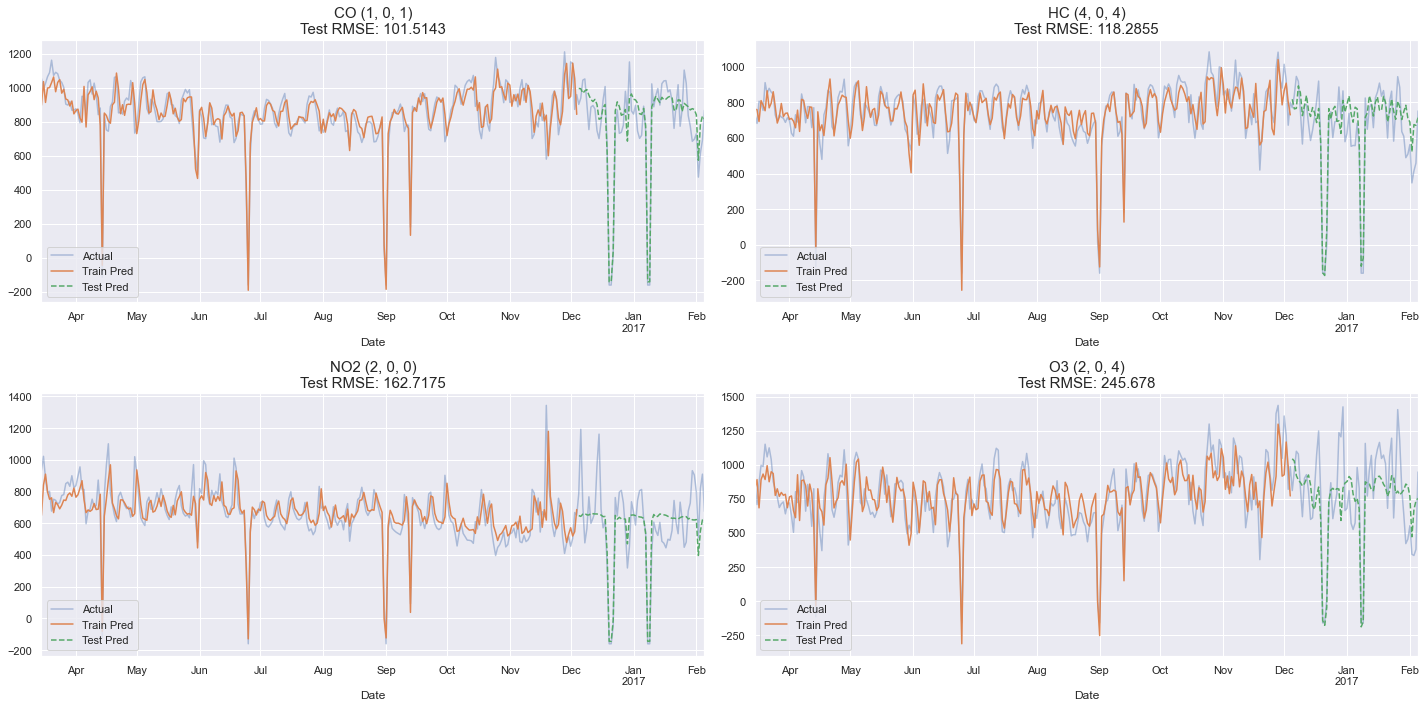

In [73]:
armax_optimal_orders = [
    ('CO', (1, 0, 1)),
    ('HC', (4, 0, 4)),
    ('NO2', (2, 0, 0)),
    ('O3', (2, 0, 4))
]

armax_summary = {}

fig8, ax8 = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

for ax, (var, order) in zip(ax8.flatten(), armax_optimal_orders):
    model = ARIMA(endog_train[var], exog=exog_train, order=order).fit()
    train_pred = model.predict(start=0, end=-1)
    test_pred = model.forecast(TEST_SIZE, exog=exog_test)

    # RMSE of validation set 
    rmse_ = round(rmse(endog_test[var], test_pred), 4)

    endog[var].plot(ax=ax, label='Actual', alpha=0.4)
    train_pred.plot(ax=ax, label='Train Pred')
    test_pred.plot(ax=ax, label='Test Pred', linestyle='--')

    ax.legend(loc='lower left')
    ax.set_title(f'{var} {order}\nTest RMSE: {rmse_}', fontsize=15)

    armax_summary.update({var : model.summary()})

plt.tight_layout()
plt.show()

In [42]:
armax_summary['CO']

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     CO   No. Observations:                  265
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1496.989
Date:                Tue, 09 Aug 2022   AIC                           3007.978
Time:                        12:04:55   BIC                           3033.036
Sample:                    03-15-2016   HQIC                          3018.046
                         - 12-04-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        702.8868     19.693     35.692      0.000     664.289     741.484
T              0.8799      0.559      1.573      0.116      -0.216       1.976
RH             3.3372      0.497      6.710      0.000       2.362       4.312
ar.L1          0.5658      0.118      4.814      0.000       0.335       0.796
ma.L1          0.2791      0.131      2.132      0.033       0.023       0.536
ma.L2          0.0114      0.095      0.120      0.904      -0.175       0.198
sigma2      4708.9645    358.022     13.153      0.000    4007.254    5410.675
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 8.47
Prob(Q):                              0.92   Prob(JB):                         0.01
Heteroskedasticity (H):               1.36   Skew:                            -0.24
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
armax_summary['HC']

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     HC   No. Observations:                  265
Model:                 ARIMA(4, 0, 4)   Log Likelihood               -1517.882
Date:                Tue, 09 Aug 2022   AIC                           3059.765
Time:                        12:04:55   BIC                           3102.721
Sample:                    03-15-2016   HQIC                          3077.024
                         - 12-04-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        628.3260     19.760     31.797      0.000     589.597     667.055
T              1.7070      0.626      2.727      0.006       0.480       2.934
RH             2.0689      0.563      3.672      0.000       0.965       3.173
ar.L1          0.4336      0.165      2.627      0.009       0.110       0.757
ar.L2         -1.1461      0.087    -13.165      0.000      -1.317      -0.975
ar.L3          0.6181      0.126      4.901      0.000       0.371       0.865
ar.L4         -0.5455      0.129     -4.236      0.000      -0.798      -0.293
ma.L1          0.2905      0.154      1.890      0.059      -0.011       0.592
ma.L2          1.3914      0.123     11.292      0.000       1.150       1.633
ma.L3          0.0455      0.160      0.285      0.776      -0.268       0.359
ma.L4          0.5467      0.101      5.429      0.000       0.349       0.744
sigma2      6871.7847    795.765      8.635      0.000    5312.114    8431.455
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.74   Prob(JB):                         0.97
Heteroskedasticity (H):               1.53   Skew:                             0.03
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
armax_summary['NO2']

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    NO2   No. Observations:                  265
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1592.872
Date:                Tue, 09 Aug 2022   AIC                           3197.744
Time:                        12:04:55   BIC                           3219.222
Sample:                    03-15-2016   HQIC                          3206.373
                         - 12-04-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        599.9042     31.736     18.903      0.000     537.702     662.106
T              3.6159      0.856      4.224      0.000       1.938       5.294
RH             0.1063      0.730      0.146      0.884      -1.325       1.537
ar.L1          0.7562      0.044     17.108      0.000       0.670       0.843
ar.L2         -0.0844      0.065     -1.307      0.191      -0.211       0.042
sigma2      9673.2305    432.716     22.355      0.000    8825.122    1.05e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1516.25
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.63   Skew:                             2.03
Prob(H) (two-sided):                  0.02   Kurtosis:                        13.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
armax_summary['O3']

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     O3   No. Observations:                  265
Model:                 ARIMA(2, 0, 4)   Log Likelihood               -1675.985
Date:                Tue, 09 Aug 2022   AIC                           3371.970
Time:                        12:04:56   BIC                           3407.768
Sample:                    03-15-2016   HQIC                          3386.353
                         - 12-04-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        608.5349     31.665     19.218      0.000     546.472     670.598
T              0.0840      0.968      0.087      0.931      -1.813       1.981
RH             3.9588      0.851      4.653      0.000       2.291       5.626
ar.L1          1.2301      0.012    100.658      0.000       1.206       1.254
ar.L2         -0.9917      0.011    -88.453      0.000      -1.014      -0.970
ma.L1         -0.5273      0.073     -7.240      0.000      -0.670      -0.385
ma.L2          0.4017      0.078      5.168      0.000       0.249       0.554
ma.L3          0.3659      0.070      5.199      0.000       0.228       0.504
ma.L4          0.2340      0.067      3.489      0.000       0.103       0.365
sigma2      1.935e+04   1761.156     10.986      0.000    1.59e+04    2.28e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 1.58
Prob(Q):                              0.67   Prob(JB):                         0.45
Heteroskedasticity (H):               1.36   Skew:                             0.13
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**<u>Observations</u>**

- From the cross-validated result as visualising the best orders, ARMAX seems much better at capturing the general trend of movement of each time series than an ARMA model. 
- However, it can be noted that the p-values from Ljung-Box test that each ARMAX model contains residuals with significant autocorrelation. This suggests that ARMAX models fail to capture some sort of correlation that happens every week (i.e a seasonal pattern)

### **SARIMAX** 

SARIMAX stands for Seasonal Auto Regressive Integrated Moving Average with eXogenous variables

From the previous seasonal decomposition, it was observed that each time series displayed strong weekly seasonal patterns. Hence I would like to see if taking exogenous variables as well as seasonality into account will improve forecast predictions.

#### Finding seasonal order

Along with finding the ARIMA components ($p$, $d$, $q$) which does not consider seasonality, SARIMAX requires additional seasonal compenents ($P$, $D$, $Q$, $m$) as well as exogenous variables

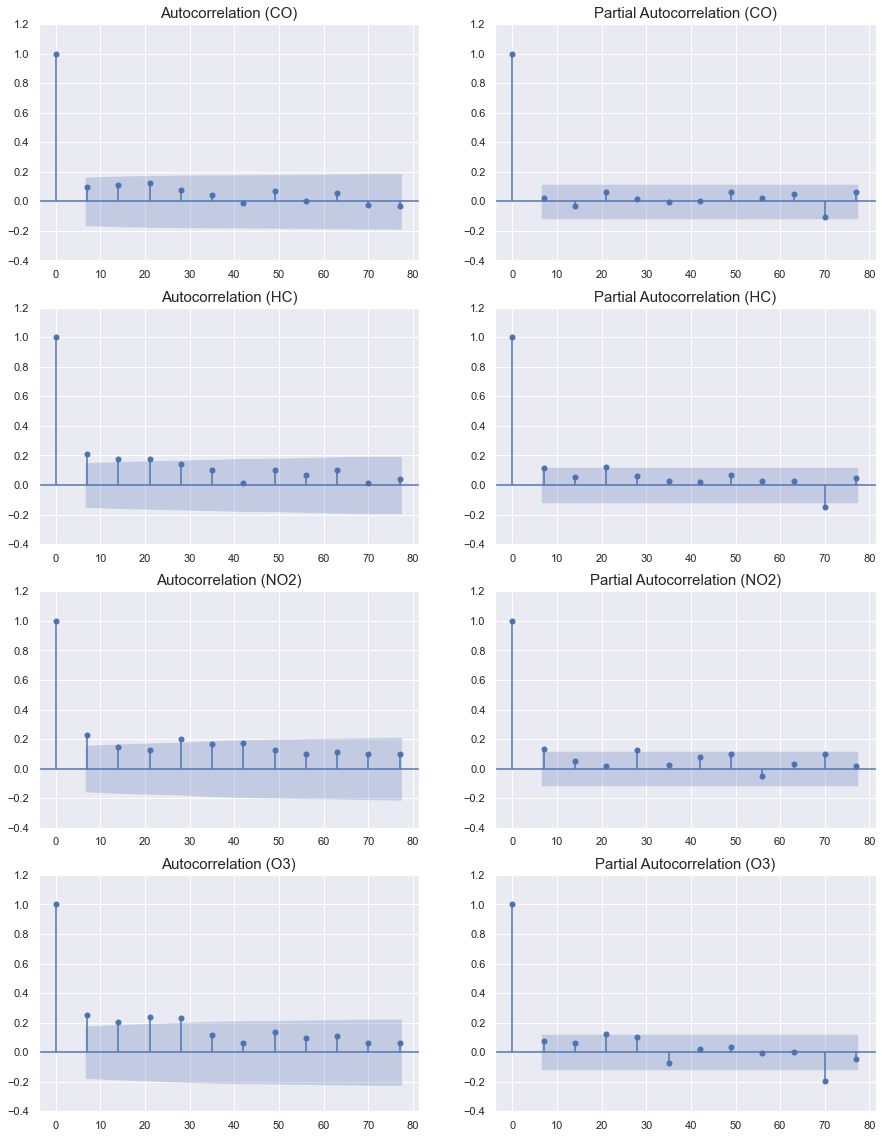

In [73]:
# ACF &  PACF plots
fig9, axes9 = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

for idx, gas in enumerate(gases):
    # I only want to obeserve the seasonal lags which are every 7 lags
    plot_acf(endog_train[gas], lags=np.arange(0, 84, 7), ax=axes9[idx, 0], alpha=0.05)
    plot_pacf(endog_train[gas], lags=np.arange(0, 84, 7), ax=axes9[idx, 1], alpha=0.05)

    axes9[idx, 0].set_title(f'Autocorrelation ({gas})', fontsize=15)
    axes9[idx, 1].set_title(f'Partial Autocorrelation ({gas})', fontsize=15)
    
    axes9[idx, 0].set_ylim(top=1.2, bottom=-.4)
    axes9[idx, 1].set_ylim(top=1.2, bottom=-.4)

plt.show()

#### Interpreted SARIMAX Model

I will be using the orders I got from previously hyperparameter tuning the ARMAX model and select the seasonal order from the ACF and PACF plots at seasonal lags of 7.

|  Gas  |      ($p$, $d$, $q$)     |   ($P$, $D$, $Q$)$m$    |  
|:-----:|:------------------------:|:-----------------------:|
|  CO   |         (1, 0, 1)        |        (0, 0, 1, 7)     |		
|  HC   |         (4, 0, 4)        |        (1, 0, 1, 7)     |    	
|  NO2  |         (2, 0, 0)        |        (2, 0, 4, 7)     |  		
|  O3   |         (2, 0, 4)        |        (0, 0, 4, 7)     |   


In [74]:
# I will use the orders I got from ARMAX CV
arima_orders = {
    'CO' : (1, 0, 1),
    'HC' : (4, 0, 4),
    'NO2' : (2, 0, 0),
    'O3' : (2, 0, 4)
}

# I will use my interpreted seasonal orders here
seasonal_orders = {
    'CO' : (0, 0, 1, 7), 
    'HC' : (1, 0, 1, 7), 
    'NO2' : (2, 0, 4, 7), 
    'O3' : (0, 0, 4, 7)
}

tscv(SARIMAX, endog_train, exog=exog_train, order_dict=arima_orders, seasonal_orders=seasonal_orders, trend='c')

,MSE,RMSE,MAE,MAPE,AIC
"CO (1, 0, 1) (0, 0, 1, 7)",33468.254755,155.932311,103.830975,1.648111,869.251411
"HC (4, 0, 4) (1, 0, 1, 7)",54724.094068,196.715187,99.047637,1.572185,991.606766
"NO2 (2, 0, 0) (2, 0, 4, 7)",179798.561599,325.069416,161.510722,2.563662,940.331928
"O3 (2, 0, 4) (0, 0, 4, 7)",388306.733217,467.246337,204.036698,3.238678,971.939555


### Hyperparameter Tuning: SARIMAX

In [43]:
sarimax = {'SARIMAX' : SARIMAX}

p_range = np.arange(3)
q_range = np.arange(3)
d_range = [0 for i in range(1)]

P_range = np.arange(3)
D_range = np.arange(1)
Q_range = np.arange(3)
m_range = np.array([7, 14, 21])

#### CO

In [124]:
co_sarimax_res = evaluate_models(sarimax, endog_train, exog=exog_train, var='CO', p_values=p_range, d_values=d_range, q_values=q_range,
                                    P_values=P_range, D_values=D_range, Q_values=Q_range, m_values=m_range)

Iteration 1		(0, 0, 0) (0, 0, 0, 7)		RMSE: 207.6085		AIC: 976.4802
Iteration 2		(0, 0, 0) (0, 0, 0, 14)		RMSE: 207.6085		AIC: 976.4802
Iteration 3		(0, 0, 0) (0, 0, 0, 21)		RMSE: 207.6085		AIC: 976.4802
Iteration 4		(0, 0, 0) (0, 0, 1, 7)		RMSE: 216.8062		AIC: 975.0598
Iteration 5		(0, 0, 0) (0, 0, 1, 14)		RMSE: 218.7807		AIC: 976.3206
Iteration 6		(0, 0, 0) (0, 0, 1, 21)		RMSE: 206.8159		AIC: 977.2251
Iteration 7		(0, 0, 0) (0, 0, 2, 7)		RMSE: 225.4232		AIC: 975.0864
Iteration 8		(0, 0, 0) (0, 0, 2, 14)		RMSE: 218.1525		AIC: 977.9231
Iteration 9		(0, 0, 0) (0, 0, 2, 21)		RMSE: 212.473		AIC: 980.8702
Iteration 10		(0, 0, 0) (1, 0, 0, 7)		RMSE: 224.0631		AIC: 973.3641
Iteration 11		(0, 0, 0) (1, 0, 0, 14)		RMSE: 218.4663		AIC: 976.2538
Iteration 12		(0, 0, 0) (1, 0, 0, 21)		RMSE: 205.9339		AIC: 976.8803
Iteration 13		(0, 0, 0) (1, 0, 1, 7)		RMSE: 184.831		AIC: 938.2523
Iteration 14		(0, 0, 0) (1, 0, 1, 14)		RMSE: 211.2298		AIC: 976.5114
Iteration 15		(0, 0, 0) (1, 0, 1, 21)		RMSE: 200.2

In [125]:
co_sarimax_res.sort_values('AIC').head().style.apply(lambda x: ['background-color: green; color: white' if v else '' for v in x == x.min()])

,RMSE,MAPE,AIC
SARIMAX,,,
"(1, 0, 2) (2, 0, 1, 7)",3099.727500,38.801200,593.638500
"(1, 0, 2) (2, 0, 2, 21)",12685.236300,197.505100,598.977400
"(2, 0, 1) (2, 0, 1, 14)",477.167700,6.642500,603.213000
"(1, 0, 2) (1, 0, 0, 14)",171.454300,1.879300,880.967700
"(1, 0, 2) (2, 0, 0, 7)",174.205800,1.892300,882.155600


#### HC

In [44]:
hc_sarimax_res = evaluate_models(sarimax, endog_train, exog=exog_train, var='HC', p_values=p_range, d_values=d_range, q_values=q_range,
                                    P_values=P_range, D_values=D_range, Q_values=Q_range, m_values=m_range)

Iteration 1		(0, 0, 0) (0, 0, 0, 7)		RMSE: 169.0861		AIC: 957.941
Iteration 2		(0, 0, 0) (0, 0, 0, 14)		RMSE: 169.0861		AIC: 957.941
Iteration 3		(0, 0, 0) (0, 0, 0, 21)		RMSE: 169.0861		AIC: 957.941
Iteration 4		(0, 0, 0) (0, 0, 1, 7)		RMSE: 173.203		AIC: 955.8148
Iteration 5		(0, 0, 0) (0, 0, 1, 14)		RMSE: 171.7744		AIC: 955.6114
Iteration 6		(0, 0, 0) (0, 0, 1, 21)		RMSE: 167.8621		AIC: 957.9205
Iteration 7		(0, 0, 0) (0, 0, 2, 7)		RMSE: 176.1569		AIC: 954.6421
Iteration 8		(0, 0, 0) (0, 0, 2, 14)		RMSE: 172.145		AIC: 956.6825
Iteration 9		(0, 0, 0) (0, 0, 2, 21)		RMSE: 166.3879		AIC: 957.415
Iteration 10		(0, 0, 0) (1, 0, 0, 7)		RMSE: 174.0445		AIC: 953.209
Iteration 11		(0, 0, 0) (1, 0, 0, 14)		RMSE: 171.5241		AIC: 954.5793
Iteration 12		(0, 0, 0) (1, 0, 0, 21)		RMSE: 166.8995		AIC: 957.2515
Iteration 13		(0, 0, 0) (1, 0, 1, 7)		RMSE: 149.4974		AIC: 907.3843
Iteration 14		(0, 0, 0) (1, 0, 1, 14)		RMSE: 152.4914		AIC: 933.7531
Iteration 15		(0, 0, 0) (1, 0, 1, 21)		RMSE: 165.9684		

In [45]:
hc_sarimax_res.sort_values('AIC').head().style.apply(lambda x: ['background-color: green; color: white' if v else '' for v in x == x.min()])

,RMSE,MAPE,AIC
SARIMAX,,,
"(2, 0, 0) (2, 0, 2, 21)",5496.693200,85.144600,610.409000
"(1, 0, 2) (1, 0, 1, 14)",10579.181800,165.804300,697.835700
"(2, 0, 1) (1, 0, 1, 7)",139.491000,1.498600,878.133800
"(1, 0, 2) (1, 0, 1, 7)",138.824200,1.493200,878.565700
"(1, 0, 2) (1, 0, 2, 7)",138.046000,1.481100,879.886300


#### NO2

In [46]:
no2_sarimax_res = evaluate_models(sarimax, endog_train, exog=exog_train, var='NO2', p_values=p_range, d_values=d_range, q_values=q_range,
                                    P_values=P_range, D_values=D_range, Q_values=Q_range, m_values=m_range)

Iteration 1		(0, 0, 0) (0, 0, 0, 7)		RMSE: 181.8254		AIC: 985.7152
Iteration 2		(0, 0, 0) (0, 0, 0, 14)		RMSE: 181.8254		AIC: 985.7152
Iteration 3		(0, 0, 0) (0, 0, 0, 21)		RMSE: 181.8254		AIC: 985.7152
Iteration 4		(0, 0, 0) (0, 0, 1, 7)		RMSE: 181.1152		AIC: 986.6635
Iteration 5		(0, 0, 0) (0, 0, 1, 14)		RMSE: 181.5716		AIC: 982.5418
Iteration 6		(0, 0, 0) (0, 0, 1, 21)		RMSE: 181.8807		AIC: 987.6211
Iteration 7		(0, 0, 0) (0, 0, 2, 7)		RMSE: 180.9989		AIC: 983.4025
Iteration 8		(0, 0, 0) (0, 0, 2, 14)		RMSE: 178.5508		AIC: 981.8818
Iteration 9		(0, 0, 0) (0, 0, 2, 21)		RMSE: 184.9274		AIC: 989.4927
Iteration 10		(0, 0, 0) (1, 0, 0, 7)		RMSE: 181.2265		AIC: 986.5153
Iteration 11		(0, 0, 0) (1, 0, 0, 14)		RMSE: 177.986		AIC: 981.1614
Iteration 12		(0, 0, 0) (1, 0, 0, 21)		RMSE: 181.821		AIC: 987.6253
Iteration 13		(0, 0, 0) (1, 0, 1, 7)		RMSE: 158.4052		AIC: 969.5166
Iteration 14		(0, 0, 0) (1, 0, 1, 14)		RMSE: 175.5811		AIC: 982.5369
Iteration 15		(0, 0, 0) (1, 0, 1, 21)		RMSE: 183.3

In [47]:
no2_sarimax_res.sort_values('AIC').head().style.apply(lambda x: ['background-color: green; color: white' if v else '' for v in x == x.min()])

,RMSE,MAPE,AIC
SARIMAX,,,
"(1, 0, 2) (1, 0, 0, 14)",153.572500,1.881300,912.460600
"(1, 0, 2) (1, 0, 1, 14)",151.622400,1.831000,912.871300
"(1, 0, 2) (0, 0, 1, 14)",155.101300,1.894500,913.207900
"(1, 0, 2) (2, 0, 0, 14)",152.701400,1.861300,913.753400
"(1, 0, 2) (2, 0, 0, 7)",161.340000,1.977100,913.907700


#### O3

In [48]:
o3_sarimax_res = evaluate_models(sarimax, endog_train, exog=exog_train, var='O3', p_values=p_range, d_values=d_range, q_values=q_range,
                                    P_values=P_range, D_values=D_range, Q_values=Q_range, m_values=m_range)

Iteration 1		(0, 0, 0) (0, 0, 0, 7)		RMSE: 242.5597		AIC: 1018.4612
Iteration 2		(0, 0, 0) (0, 0, 0, 14)		RMSE: 242.5597		AIC: 1018.4612
Iteration 3		(0, 0, 0) (0, 0, 0, 21)		RMSE: 242.5597		AIC: 1018.4612
Iteration 4		(0, 0, 0) (0, 0, 1, 7)		RMSE: 246.0271		AIC: 1016.1719
Iteration 5		(0, 0, 0) (0, 0, 1, 14)		RMSE: 253.9534		AIC: 1013.7208
Iteration 6		(0, 0, 0) (0, 0, 1, 21)		RMSE: 242.22		AIC: 1018.1076
Iteration 7		(0, 0, 0) (0, 0, 2, 7)		RMSE: 254.5204		AIC: 1013.0388
Iteration 8		(0, 0, 0) (0, 0, 2, 14)		RMSE: 256.8813		AIC: 1014.5421
Iteration 9		(0, 0, 0) (0, 0, 2, 21)		RMSE: 240.4061		AIC: 1016.0849
Iteration 10		(0, 0, 0) (1, 0, 0, 7)		RMSE: 250.3795		AIC: 1013.471
Iteration 11		(0, 0, 0) (1, 0, 0, 14)		RMSE: 255.3618		AIC: 1011.6238
Iteration 12		(0, 0, 0) (1, 0, 0, 21)		RMSE: 240.9403		AIC: 1017.0057
Iteration 13		(0, 0, 0) (1, 0, 1, 7)		RMSE: 238.7508		AIC: 1002.6428
Iteration 14		(0, 0, 0) (1, 0, 1, 14)		RMSE: 248.6077		AIC: 1010.5438
Iteration 15		(0, 0, 0) (1, 0, 1, 21)

In [49]:
o3_sarimax_res.sort_values('AIC').head().style.apply(lambda x: ['background-color: green; color: white' if v else '' for v in x == x.min()])

,RMSE,MAPE,AIC
SARIMAX,,,
"(2, 0, 0) (1, 0, 1, 21)",12072.680400,188.742700,653.708800
"(1, 0, 0) (2, 0, 2, 14)",7138.478800,88.565500,655.650900
"(1, 0, 2) (1, 0, 1, 7)",204.633700,2.570500,966.783100
"(1, 0, 2) (2, 0, 0, 7)",229.657500,2.875300,969.234400
"(1, 0, 2) (2, 0, 1, 7)",204.481500,2.534400,969.589300


#### Summary of SARIMAX CV Results


|  Gas  |  ARIMA Order  |  Seasonal Order  |       RMSE      |       AIC       |   Baseline RMSE   |     Baseline AIC    |
|:-----:|:-------------:|:----------------:|:---------------:|:---------------:|:-----------------:|:-------------------:| 
|  CO   |   (1, 0, 2)   |  (1, 0, 0, 14)   |   171.454300    |   880.967700    |     135.670916    |     803.999919      | 	
|  HC   |   (2, 0, 0)   |  (2, 0, 2, 21)   |   5496.693200   |   610.409000    |     106.049750    |     825.420847      |	
|  NO2  |   (1, 0, 2)   |  (1, 0, 1, 14)   |   153.572500    |   912.460600    |     101.826045    |     815.264117      |
|  O3   |   (1, 0, 2)   |  (2, 0, 1, 7)    |   204.481500    |   969.589300    |     177.263363    |     896.636217      | 

#### Visualising SARIMAX Forecasts

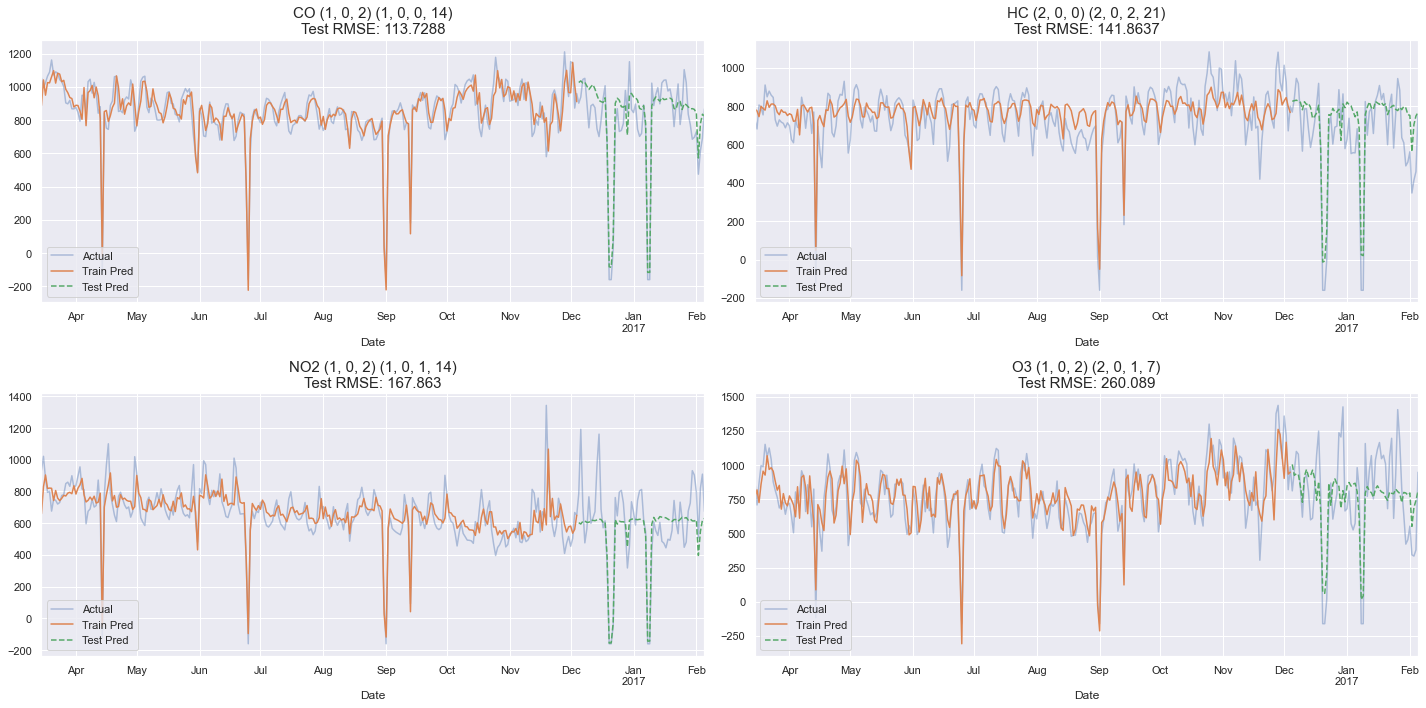

In [60]:
sarimax_optimal_orders = [
    ('CO', ((1, 0, 2), (1, 0, 0, 14))),
    ('HC', ((2, 0, 0), (2, 0, 2, 21))),
    ('NO2', ((1, 0, 2), (1, 0, 1, 14))),
    ('O3', ((1, 0, 2), (2, 0, 1, 7)))
]

sarimax_summary = {}

fig10, ax10 = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

for ax, (var, (order, s_order)) in zip(ax10.flatten(), sarimax_optimal_orders):
    model = SARIMAX(endog_train[var], exog_train, order=order, seasonal_order=s_order, trend='c').fit()
    train_pred = model.predict(start=0, end=-1, exog=exog_test)
    test_pred = model.forecast(TEST_SIZE, exog=exog_test)

    rmse_ = round(rmse(endog_test[var], test_pred), 4)

    endog[var].plot(ax=ax, label='Actual', alpha=0.4)
    train_pred.plot(ax=ax, label='Train Pred')
    test_pred.plot(ax=ax, label='Test Pred', linestyle='--')

    ax.legend(loc='lower left')
    ax.set_title(f'{var} {order} {s_order}\nTest RMSE: {rmse_}', fontsize=15)

    sarimax_summary.update({var : model.summary()})

plt.tight_layout()
plt.show()

In [61]:
sarimax_summary['CO']

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                  CO   No. Observations:                  265
Model:             SARIMAX(1, 0, 2)x(1, 0, [], 14)   Log Likelihood               -1500.011
Date:                             Fri, 12 Aug 2022   AIC                           3016.022
Time:                                     22:07:36   BIC                           3044.660
Sample:                                 03-15-2016   HQIC                          3027.529
                                      - 12-04-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     35.3710     25.827      1.370      0.171     -15.249      85.991
T              1.7991      0.591      3.042      0.002       0.640       2.958
RH             2.5125      0.526      4.775      0.000       1.481       3.544
ar.L1          0.9403      0.044     21.448      0.000       0.854       1.026
ma.L1         -0.1646      0.079     -2.086      0.037      -0.319      -0.010
ma.L2         -0.3435      0.067     -5.106      0.000      -0.475      -0.212
ar.S.L14       0.1857      0.062      2.990      0.003       0.064       0.307
sigma2      4803.4403    388.426     12.366      0.000    4042.139    5564.742
===================================================================================
Ljung-Box (L1) (Q):                   1.27   Jarque-Bera (JB):                 9.03
Prob(Q):                              0.26   Prob(JB):                         0.01
Heteroskedasticity (H):               1.51   Skew:                            -0.18
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
sarimax_summary['HC']

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                      HC   No. Observations:                  265
Model:             SARIMAX(2, 0, 0)x(2, 0, [1, 2], 21)   Log Likelihood               -1645.626
Date:                                 Fri, 12 Aug 2022   AIC                           3311.251
Time:                                         22:07:42   BIC                           3347.049
Sample:                                     03-15-2016   HQIC                          3325.634
                                          - 12-04-2016                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     55.2046    353.013      0.156      0.876    -636.688     747.097
T              2.1453      2.293      0.936      0.349      -2.349       6.639
RH             1.3108      2.013      0.651      0.515      -2.634       5.256
ar.L1          0.3322      0.283      1.172      0.241      -0.223       0.888
ar.L2         -0.0711      0.275     -0.259      0.796      -0.610       0.468
ar.S.L21       1.7868      2.962      0.603      0.546      -4.019       7.593
ar.S.L42      -0.8954      2.358     -0.380      0.704      -5.518       3.727
ma.S.L21      -1.7442      3.324     -0.525      0.600      -8.259       4.770
ma.S.L42       0.8863      2.494      0.355      0.722      -4.002       5.775
sigma2      3.019e+04   1.52e+04      1.989      0.047     447.755    5.99e+04
===================================================================================
Ljung-Box (L1) (Q):                  39.55   Jarque-Bera (JB):                 0.12
Prob(Q):                              0.00   Prob(JB):                         0.94
Heteroskedasticity (H):               1.59   Skew:                            -0.05
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
sarimax_summary['NO2']

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                  NO2   No. Observations:                  265
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 14)   Log Likelihood               -1592.680
Date:                              Fri, 12 Aug 2022   AIC                           3203.360
Time:                                      22:07:43   BIC                           3235.578
Sample:                                  03-15-2016   HQIC                          3216.305
                                       - 12-04-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     26.2857     34.099      0.771      0.441     -40.546      93.118
T              3.9362      0.923      4.267      0.000       2.128       5.744
RH            -0.2395      0.780     -0.307      0.759      -1.768       1.289
ar.L1          0.9786      0.016     62.917      0.000       0.948       1.009
ma.L1         -0.3879      0.051     -7.599      0.000      -0.488      -0.288
ma.L2         -0.4140      0.053     -7.781      0.000      -0.518      -0.310
ar.S.L14      -0.9643      2.089     -0.462      0.644      -5.058       3.130
ma.S.L14       0.9682      2.057      0.471      0.638      -3.064       5.000
sigma2      9650.0895    633.772     15.226      0.000    8407.919    1.09e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.69   Jarque-Bera (JB):              2114.63
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               1.83   Skew:                             2.37
Prob(H) (two-sided):                  0.01   Kurtosis:                        16.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [64]:
sarimax_summary['O3']

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                  O3   No. Observations:                  265
Model:             SARIMAX(1, 0, 2)x(2, 0, [1], 7)   Log Likelihood               -1728.446
Date:                             Fri, 12 Aug 2022   AIC                           3476.892
Time:                                     22:07:44   BIC                           3512.689
Sample:                                 03-15-2016   HQIC                          3491.275
                                      - 12-04-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     50.5195    111.205      0.454      0.650    -167.437     268.476
T              5.3014      3.517      1.508      0.132      -1.591      12.194
RH            -1.1682      3.082     -0.379      0.705      -7.209       4.872
ar.L1          0.5497      0.393      1.398      0.162      -0.221       1.320
ma.L1          0.2173      0.434      0.500      0.617      -0.634       1.068
ma.L2          0.0286      0.297      0.096      0.923      -0.554       0.612
ar.S.L7        0.8207      0.584      1.406      0.160      -0.323       1.965
ar.S.L14       0.0325      0.348      0.093      0.926      -0.650       0.715
ma.S.L7       -0.6233      0.545     -1.144      0.253      -1.691       0.445
sigma2      5.365e+04   8032.719      6.679      0.000    3.79e+04    6.94e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 3.21
Prob(Q):                              0.80   Prob(JB):                         0.20
Heteroskedasticity (H):               1.43   Skew:                             0.20
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**<u>Observations</u>**

- From the cross-validated result as visualising the best orders, SARIMAX seems much better at capturing the general trend of movement of each time series than an ARMA or ARMAX model. 
- However, it can be noted that the p-values from Ljung-Box test for SARIMAX models on `CO`, `HC`, `NO2` still contains residuals with significant autocorrelation. This may prompt us to try refitting our models.
- The p-values from Ljung-Box test for SARIMAX models on `O3` is less than 5%. Hence, a SARIMAX model may be the right choice for forecasting trioxygen pollutants.

## Final Forecast Models


|  Gas  |       Model   |
|:-----:|:-------------:| 
|  CO   |   ARMAX (1, 1)   | 	
|  HC   |   ARMAX (4, 4)   |	
|  NO2  |   ARMAX (2, 0)   |
|  O3   |   SARIMAX (1, 0, 2) (2, 0, 1, 7)  | 


In [65]:
# ARMAX (1, 1)
co_model = ARIMA(endog_train['CO'], exog=exog_train, order=(1, 0, 1), trend='c').fit()
# ARMAX (4, 4)
hc_model = ARIMA(endog_train['HC'], exog=exog_train, order=(4, 0, 4), trend='c').fit()
# ARMAX (2, 0)
no2_model = ARIMA(endog_train['NO2'], exog=exog_train, order=(2, 0, 0), trend='c').fit()
# SARIMAX (1, 0, 2) (2, 0 , 1, 7)
o3_model = SARIMAX(endog_train['O3'], exog=exog_train, order=(1, 0, 2), seasonal_order=(2, 0, 1, 7) , trend='c').fit()

isExist = os.path.exists(path='./models/')

if not isExist:
    os.makedirs('./models/time_series/')

with open('./models/time_series/forecast_models.pkl', 'wb') as f:
    pickle.dump((co_model, hc_model, no2_model, o3_model), f)
    f.close()
    
    print('models saved!')

models saved!


In [66]:
with open('./models/time_series/forecast_models.pkl', 'rb') as f:
    models = [] 
    while True: 
        try:             
            m = pickle.load(f) 
        except EOFError: 
            break 
        models.append(m)
    f.close()
    print('models loaded!')

models loaded!


## Generating Kaggle Predictions

### Importing Test Data

In [67]:
test_data = pd.read_csv('data/Air Pollution Dataset/test.csv')
test_data.drop(['id', 'Unnamed: 5', 'Unnamed: 6'], axis=1, inplace=True)
test_data['Date'] = pd.to_datetime(test_data['Date'], format='%d/%m/%Y')
test_data.set_index('Date', inplace=True)

In [68]:
test_data.head()

,T,RH,Gas
Date,,,
2017-02-06,6.616667,51.734375,CO
2017-02-07,7.613194,43.930903,CO
2017-02-08,7.252083,50.966667,CO
2017-02-09,7.473611,50.166319,CO
2017-02-10,5.571875,46.604167,CO


### Generating Predictions

In [69]:
test_df = test_data.copy(deep=True)
submission_dict = {}

for gas, model in zip(gases, models[0]):
    pred = model.forecast(steps=len(test_df[test_df['Gas'] == gas]), exog=test_data[test_df['Gas'] == gas][t_rh])
    submission_dict.update({gas : pred})
    print(gas, 'done...')

submission_df = pd.DataFrame.from_dict(submission_dict, orient='columns')

CO done...
HC done...
NO2 done...
O3 done...


In [70]:
submission_df.head()

,CO,HC,NO2,O3
2016-12-05,923.692524,765.697754,622.790832,993.919415
2016-12-06,880.589126,689.556983,627.687236,945.952637
2016-12-07,893.336329,712.112340,628.758037,921.662359
2016-12-08,884.888182,824.149902,630.526270,920.816613
2016-12-09,867.888536,770.883952,623.929482,851.140526


In [71]:
submission_df = pd.melt(submission_df, value_vars=gases, var_name='Gas', value_name='Value').drop(columns='Gas', axis=1).rename_axis(index='id')
submission_df.head()

,Value
id,
0,923.692524
1,880.589126
2,893.336329
3,884.888182
4,867.888536


### Saving Test Predictions

In [72]:
submission_df.to_csv('data/submission.csv', index=True)

## Conclusion

Although I may not be the best at this module, learning about time series and applying what I have learnt in this module has been very fun and enriching. From learning the different forecast models to the math behind each each concept. One challenge I had was interpreting the ACF and PACF plots as different people have their own interpretations when discerning a models order. I will definitely delve deeper on this topic during my free time with other projects.

![](https://i.imgur.com/iz7vS8S.jpg)<br>
<!-- [Source](https://makeameme.org/meme/thank-you-jrtxcq) -->

## References

- Epa.gov. 2016. Technical Note ‐ Reporting Negative Values for Criteria Pollutant Gaseous Monitors to AQS. [online] Available at: <https://www.epa.gov/sites/default/files/2017-02/documents/negative_values_reporting_to_aqs_10_6_16.pdf> [Accessed 12 August 2022].

- Ftp.cpc.ncep.noaa.gov. 2000. Humidity. [online] Available at: <https://ftp.cpc.ncep.noaa.gov/wd51we/reanal/random_notes/humidity> [Accessed 12 August 2022].

- Community.ibm.com. 2021. Tukey Fences for Outliers. [online] Available at: <https://community.ibm.com/community/user/datascience/blogs/moloy-de1/2021/03/23/points-to-ponder> [Accessed 12 August 2022].